In [1]:
!pip install sympy==1.12


  Using cached sympy-1.12-py3-none-any.whl.metadata (12 kB)
Using cached sympy-1.12-py3-none-any.whl (5.7 MB)
  Attempting uninstall: sympy
    Found existing installation: sympy 1.14.0
    Uninstalling sympy-1.14.0:
      Successfully uninstalled sympy-1.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.9.0+cu126 requires sympy>=1.13.3, but you have sympy 1.12 which is incompatible.


In [2]:
!pip install torch-vggish-yamnet #PyTorch wrapper library that lets you load and use YAMNet it gives pretrained YAMNet embeddings


  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
Using cached sympy-1.14.0-py3-none-any.whl (6.3 MB)
  Attempting uninstall: sympy
    Found existing installation: sympy 1.12
    Uninstalling sympy-1.12:
      Successfully uninstalled sympy-1.12


In [3]:
#It downloads the ZIP file containing the ESC-50 dataset and extracts all the .wav audio files.
!wget https://github.com/karoldvl/ESC-50/archive/master.zip
!unzip master.zip -d ESC50


--2025-12-11 14:40:43--  https://github.com/karoldvl/ESC-50/archive/master.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 503 Service Unavailable
2025-12-11 14:40:46 ERROR 503: Service Unavailable.

Archive:  master.zip
33c8ce9eb2cf0b1c2f8bcf322eb349b6be34dbb6
replace ESC50/ESC-50-master/.circleci/config.yml? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ESC50/ESC-50-master/.circleci/config.yml  
  inflating: ESC50/ESC-50-master/.github/stale.yml  
 extracting: ESC50/ESC-50-master/.gitignore  
  inflating: ESC50/ESC-50-master/LICENSE  
  inflating: ESC50/ESC-50-master/README.md  
  inflating: ESC50/ESC-50-master/audio/1-100032-A-0.wav  
  inflating: ESC50/ESC-50-master/audio/1-100038-A-14.wav  
  inflating: ESC50/ESC-50-master/audio/1-100210-A-36.wav  
  inflating: ESC50/ESC-50-master/audio/1-100210-B-36.wav  
  inflating: ESC50/ESC-50-master/audio/1-101296-A-

In [4]:
#Download GTZAN
import kagglehub

path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")
print("✅ Dataset downloaded to:", path)


Using Colab cache for faster access to the 'gtzan-dataset-music-genre-classification' dataset.
✅ Dataset downloaded to: /kaggle/input/gtzan-dataset-music-genre-classification


In [5]:
# This code loads an audio file, converts it into YAMNet’s required log-mel format, runs the frozen YAMNet model, and returns a final 1024-dimensional embedding for that sound clip.

import torch, torchaudio, soundfile as sf
from torch_vggish_yamnet import yamnet
from torch_vggish_yamnet.input_proc import WaveformToInput

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load pretrained YAMNet and the waveform→input converter
yamnet_model = yamnet.yamnet(pretrained=True).to(device).eval()
yamnet_converter = WaveformToInput()

@torch.no_grad()
def wav_to_yamnet_embedding(wave: torch.Tensor, sr: int):
    """
    wave: torch.Tensor of shape (channels, samples) or (samples,)
    sr: sampling rate
    returns: np.ndarray of shape (1024,) – frame-averaged YAMNet embedding
    """
    # Ensure shape (1, samples)
    if wave.ndim == 1:
        wave = wave.unsqueeze(0)
    # Resample to 16 kHz mono (YAMNet expects 16k)
    if sr != 16000:
        wave = torchaudio.functional.resample(wave, sr, 16000)
        sr = 16000
    wave = wave.mean(0, keepdim=True)  # mono

    x = yamnet_converter(wave.float(), sr).to(device)  # frames × features
    emb, _ = yamnet_model(x)                           # (frames, 1024)
    emb = emb.mean(dim=0).cpu().numpy()                # -> (1024,)
    return emb

def safe_load(fp):
    """Try torchaudio first, fallback to soundfile; always return (wave, sr)."""
    try:
        wave, sr = torchaudio.load(fp)
        return wave, sr
    except Exception:
        data, sr = sf.read(fp, dtype="float32")  # (samples,) or (samples, channels)
        if data.ndim == 1:
            data = data[:, None]                 # -> (samples, 1)
        wave = torch.from_numpy(data.T)          # -> (channels, samples)
        return wave, sr


In [6]:
# This code converts all ESC-50 audio clips into YAMNet’s 1024-dimensional
# embeddings and builds the dataset that will be used for zero-shot, few-shot,
# and full classification experiments.

import os
import numpy as np
import pandas as pd
from tqdm import tqdm

#Paths to ESC-50 (as you already used when downloading/unzipping)
esc_root  = "ESC50/ESC-50-master"
esc_csv   = os.path.join(esc_root, "meta/esc50.csv")
esc_audio = os.path.join(esc_root, "audio")

#Load metadata (filenames + categories)
esc_meta = pd.read_csv(esc_csv)

#Prepare containers
X, y = [], []

#Map category name -> numeric id (0..49)
label_to_id = {lbl: i for i, lbl in enumerate(sorted(esc_meta["category"].unique()))}

#Loop over all ESC-50 audio files and extract a 1024-dim embedding
for row in tqdm(esc_meta.itertuples(index=False), total=len(esc_meta)):
    wav_path = os.path.join(esc_audio, row.filename)
    try:
        # use your helper functions from the first cell
        wave, sr = safe_load(wav_path)
        emb = wav_to_yamnet_embedding(wave, sr)   # shape (1024,)
        X.append(emb)
        y.append(label_to_id[row.category])       # integer label
    except Exception as e:
        print("Failed:", wav_path, "->", e)

#Stack into arrays
X = np.stack(X).astype("float32")   # shape (N, 1024)
y = np.array(y, dtype=np.int64)     # shape (N,)

print("ESC-50 embeddings shape:", X.shape)
print("ESC-50 labels shape:", y.shape)

#Save to disk for later use
np.savez_compressed("esc50_yamnet.npz",
                    X=X,
                    y=y,
                    labels=np.array(sorted(label_to_id, key=label_to_id.get)))


100%|██████████| 2000/2000 [00:34<00:00, 57.69it/s]


ESC-50 embeddings shape: (2000, 1024, 1, 1)
ESC-50 labels shape: (2000,)


In [7]:
# This cell converts all GTZAN audio clips into 1024-D YAMNet embeddings

gtzan_root = os.path.join(path, "Data", "genres_original")
print("Using GTZAN root:", gtzan_root)
assert os.path.isdir(gtzan_root)

#Get genre subfolders
genres = sorted(
    d for d in os.listdir(gtzan_root)
    if os.path.isdir(os.path.join(gtzan_root, d))
)
print("Detected genres:", genres)

#Prepare containers
X, y = [], []
label_to_id = {g: i for i, g in enumerate(genres)}
print("Label→id mapping:", label_to_id)

#Loop over all files and extract one 1024-D embedding per clip
for genre in genres:
    genre_id = label_to_id[genre]
    folder = os.path.join(gtzan_root, genre)
    wav_files = sorted(
        f for f in os.listdir(folder)
        if f.lower().endswith(".wav")
    )

    for fn in tqdm(wav_files, desc=f"Processing {genre}", leave=False):
        wav_path = os.path.join(folder, fn)
        try:
            wave, sr = safe_load(wav_path)
            emb = wav_to_yamnet_embedding(wave, sr)  # (1024,)
            X.append(emb)
            y.append(genre_id)
        except Exception as e:
            print("Failed:", wav_path, "->", e)

#Stack into arrays
X = np.stack(X).astype("float32")  # shape (N, 1024)
y = np.array(y, dtype=np.int64)    # shape (N,)

print("GTZAN embeddings shape:", X.shape)
print("GTZAN labels shape:", y.shape)

#Save to disk for later (for your linear SVM, NC, etc.)
np.savez_compressed(
    "gtzan_yamnet.npz",
    X=X,
    y=y,
    labels=np.array(genres)
)
print("Saved gtzan_yamnet.npz")


Using GTZAN root: /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original
Detected genres: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Label→id mapping: {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}


Processing jazz:  61%|██████    | 61/100 [00:02<00:01, 31.34it/s]

Failed: /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav -> Error opening '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav': Format not recognised.


GTZAN embeddings shape: (999, 1024, 1, 1)
GTZAN labels shape: (999,)
Saved gtzan_yamnet.npz


**LINEAR MODELS FOR GTZAN**

In [8]:
import csv
import requests

url = "https://raw.githubusercontent.com/tensorflow/models/master/research/audioset/yamnet/yamnet_class_map.csv"

response = requests.get(url)
data = response.text.splitlines()

reader = csv.DictReader(data)
class_names = [row["display_name"] for row in reader]

print(len(class_names))
print(class_names[:10])


521
['Speech', 'Child speech, kid speaking', 'Conversation', 'Narration, monologue', 'Babbling', 'Speech synthesizer', 'Shout', 'Bellow', 'Whoop', 'Yell']


In [9]:
import difflib

def best_match(genre, aset_names):

    matches = difflib.get_close_matches(genre, aset_names, n=1, cutoff=0.2)
    if matches:
        return matches[0]


    fallback = {
        "pop": "Pop music",
        "rock": "Rock music",
        "hiphop": "Hip hop music",
        "disco": "Electronic dance music",
        "country": "Country",
        "metal": "Heavy metal",
    }
    if genre in fallback:
        return fallback[genre]

    # Last fallback: generic "Music"
    return "Music"


In [10]:
mapping = {g: best_match(g, class_names) for g in genres}

print("\nGTZAN → AudioSet mapping:")
for g in genres:
    print(f"{g:10s} → {mapping[g]}")



GTZAN → AudioSet mapping:
blues      → Blues
classical  → Classical music
country    → Country
disco      → Disco
hiphop     → Whip
jazz       → Jazz
metal      → Heavy metal
pop        → Plop
reggae     → Reggae
rock       → Truck


In [11]:
aset_to_idx = {label: i for i, label in enumerate(class_names)}

idx_list = []
for g in genres:
    label = mapping[g]
    idx = aset_to_idx[label]
    idx_list.append(idx)

idx_list = np.array(idx_list)
print("\nMapped AudioSet indices:", idx_list)



Mapped AudioSet indices: [246 232 224 231 466 230 215 488 223 310]


**ZERO-SHOT YAMNET CLASSFIER ON GTZAN**

In [12]:

import pickle
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix


# ============================================================
# 1. Load GTZAN embeddings (your file)
# ============================================================
data = np.load("gtzan_yamnet.npz", allow_pickle=True)
X = data["X"]      # e.g. (999, 1024, 1, 1)
y_true = data["y"]
genres = data["labels"].tolist()

print("Loaded embeddings raw shape:", X.shape)
# squeeze last dims -> (N, 1024)
X = np.reshape(X, (X.shape[0], -1)).astype("float32")
print("Embeddings after reshape:", X.shape)
print("Genres:", genres)

# ============================================================
# 2. Load YAMNet classifier (torch_vggish_yamnet)
# ============================================================
from torch_vggish_yamnet.yamnet import yamnet as YAMNet

device = "cuda" if torch.cuda.is_available() else "cpu"
model = YAMNet(pretrained=True).to(device)
model.eval()

W = model.classifier.weight.detach().cpu()   # (521, 1024)
b = model.classifier.bias.detach().cpu()     # (521,)

# ============================================================
# 3. Load official AudioSet labels from CSV
# ============================================================
url = "https://raw.githubusercontent.com/tensorflow/models/master/research/audioset/yamnet/yamnet_class_map.csv"
df = pd.read_csv(url)
class_names = df["display_name"].tolist()
print("Loaded", len(class_names), "AudioSet labels")

# ============================================================
# 4. Manual, SAFE GTZAN → AudioSet mapping (no None)
#    We rely on known label names present in the CSV
# ============================================================
target_labels = {
    "blues"    : "Blues",
    "classical": "Classical music",
    "country"  : "Country",
    "disco"    : "Disco",
    "hiphop"   : "Hip hop music",
    "jazz"     : "Jazz",
    "metal"    : "Heavy metal",
    "pop"      : "Pop music",
    "reggae"   : "Reggae",
    "rock"     : "Rock music",
}

# verify that all targets exist in class_names
missing = [lab for lab in target_labels.values() if lab not in class_names]
if missing:
    raise ValueError(f"These target labels are not in AudioSet class list: {missing}")

print("\nGTZAN → AudioSet mapping (fixed):")
for g in genres:
    print(f"{g:10s} → {target_labels[g]}")

# build index list in the same order as 'genres'
aset_to_idx = {label: i for i, label in enumerate(class_names)}
idx_list = np.array([aset_to_idx[target_labels[g]] for g in genres], dtype=int)
print("\nAudioSet indices used:", idx_list)


# 5. Zero-shot: run classifier on embeddings (measure inference time)
import time

train_time = 0.0  # zero-shot has no training
t0 = time.time()

X_tensor = torch.tensor(X)                 # (N, 1024)
logits = X_tensor @ W.T + b                # (N, 521)
selected_logits = logits[:, idx_list]      # (N, 10)
y_pred = torch.argmax(selected_logits, dim=1).numpy()

infer_time = time.time() - t0

# 6. Metrics
acc = accuracy_score(y_true, y_pred)
macro_f1 = f1_score(y_true, y_pred, average="macro")

print("\n===== ZERO-SHOT RESULTS (EMBEDDINGS + YAMNET CLASSIFIER) =====")
print("Accuracy :", acc)
print("Macro-F1 :", macro_f1)
print("Inference time (s):", infer_time)

# 7. Save results
results = pd.DataFrame([{
    "Experiment": "Zero-Shot YAMNet",
    "Labeled examples": 0,
    "Train time (s)": train_time,
    "Infer time (s)": infer_time,
    "CV macro-F1": "N/A",
    "Test macro-F1": macro_f1,
    "Test Acc": acc,
    "Best params": "N/A"
}])

results.to_csv("zero_shot_results.csv", index=False)
# Compute confusion matrix
cm_zero = confusion_matrix(y_true, y_pred)

print("\n===== ZERO-SHOT RESULTS (EMBEDDINGS + YAMNET CLASSIFIER) =====")
print("Accuracy :", acc)
print("Macro-F1 :", macro_f1)
print("Inference time (s):", infer_time)
print("\nConfusion matrix:")
print(cm_zero)

# Save confusion matrix
pd.DataFrame(cm_zero).to_csv("zero_shot_confusion_matrix.csv", index=False)
print("Saved: zero_shot_confusion_matrix.csv")





Loaded embeddings raw shape: (999, 1024, 1, 1)
Embeddings after reshape: (999, 1024)
Genres: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Loaded 521 AudioSet labels

GTZAN → AudioSet mapping (fixed):
blues      → Blues
classical  → Classical music
country    → Country
disco      → Disco
hiphop     → Hip hop music
jazz       → Jazz
metal      → Heavy metal
pop        → Pop music
reggae     → Reggae
rock       → Rock music

AudioSet indices used: [246 232 224 231 212 230 215 211 223 214]

===== ZERO-SHOT RESULTS (EMBEDDINGS + YAMNET CLASSIFIER) =====
Accuracy : 0.6356356356356356
Macro-F1 : 0.6187560933276006
Inference time (s): 0.02444291114807129

===== ZERO-SHOT RESULTS (EMBEDDINGS + YAMNET CLASSIFIER) =====
Accuracy : 0.6356356356356356
Macro-F1 : 0.6187560933276006
Inference time (s): 0.02444291114807129

Confusion matrix:
[[44  2 24  0  0  7  0  1  7 15]
 [ 0 99  0  0  0  0  0  0  0  1]
 [ 5  0 81  0  0  1  0  7  1  5]
 [ 0  1  1 49

**LOG-REGRESSION CLASSIFIER FOR GTZAN**

In [13]:
################################################################################
# FEW-SHOT GTZAN (k=5) USING LOGISTIC REGRESSION ON YAMNet EMBEDDINGS
################################################################################

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


# ============================================================
# 1. Load GTZAN embeddings
# ============================================================
data = np.load("gtzan_yamnet.npz", allow_pickle=True)
X = data["X"].reshape(data["X"].shape[0], -1).astype("float32")  # (N, 1024)
y = data["y"]
genres = data["labels"].tolist()

print("Embeddings:", X.shape)
print("Genres:", genres)

# ============================================================
# 2. FEW SHOT k = 5
# ============================================================
k = 5
rng = np.random.default_rng(seed=123)

train_idx = []
test_idx = []

# pick k=5 samples per class for training
for cls in range(len(genres)):
    cls_idx = np.where(y == cls)[0]
    chosen = rng.choice(cls_idx, size=k, replace=False)
    train_idx.extend(chosen)

    rest = np.setdiff1d(cls_idx, chosen)
    test_idx.extend(rest)

train_idx = np.array(train_idx)
test_idx = np.array(test_idx)

X_train, y_train = X[train_idx], y[train_idx]
X_test,  y_test  = X[test_idx],  y[test_idx]

print("\nTrain size:", len(train_idx))   # should be 50
print("Test size :", len(test_idx))     # around 949

#============================
# 3. Train classifier + timing
# ============================
# Define the classifier
clf = LogisticRegression(
    max_iter=500,
    solver="lbfgs",
    multi_class="multinomial"
)


import time

# Training time
start_train = time.time()
clf.fit(X_train, y_train)
train_time = time.time() - start_train

# ============================
# 4. Evaluate + inference time
# ============================

start_infer = time.time()
y_pred = clf.predict(X_test)
infer_time = time.time() - start_infer

acc = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")
cm = confusion_matrix(y_test, y_pred)

print("\n===== FEW-SHOT (k=5) RESULTS =====")
print("Accuracy :", acc)
print("Macro-F1 :", macro_f1)
print("Training time:", train_time, "seconds")
print("Inference time:", infer_time, "seconds")
print("\nConfusion matrix:")
print(cm)
# ================================================================
# Save results to CSV (confusion matrix + metrics)
# ================================================================
results_df = pd.DataFrame({
    "Genre": genres,
    "Confusion Matrix Row": [list(row) for row in cm]
})

results_df.to_csv("few_shot_k5_results.csv", index=False)
print("Saved:", "few_shot_k5_results.csv")

# ============================
# 5. Save predictions + times
# ============================

with open("fewshot_k5_predictions.pkl", "wb") as f:
    pickle.dump({
        "y_true": y_test,
        "y_pred": y_pred,
        "genres": genres,
        "confusion_matrix": cm,
        "accuracy": acc,
        "macro_f1": macro_f1,
        "train_time": train_time,
        "infer_time": infer_time
    }, f)

Embeddings: (999, 1024)
Genres: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

Train size: 50
Test size : 949


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



===== FEW-SHOT (k=5) RESULTS =====
Accuracy : 0.7492096944151738
Macro-F1 : 0.7471088821977283
Training time: 0.48510169982910156 seconds
Inference time: 0.021167516708374023 seconds

Confusion matrix:
[[49  0  9  3  0  5  4  0 14 11]
 [ 0 83  0  0  0 11  0  0  0  1]
 [ 7  0 66  2  0  2  0  0  1 17]
 [ 0  0  1 75  3  0  0 14  1  1]
 [ 0  0  0  0 79  0  4  3  5  4]
 [ 5  1  4  0  0 81  0  0  3  0]
 [ 0  0  1  0  0  0 92  0  0  2]
 [ 0  0  3  7  7  0  0 67  0 11]
 [ 3  0  1  3 10  0  0  2 73  3]
 [ 6  0 17  4  0  0 12  4  6 46]]
Saved: few_shot_k5_results.csv


**NEAREST-CENTROID WITH COSINE CLASSIFIER FOR GTZAN k=5**

In [14]:
###############################################################
# FEW-SHOT (k=5) using Nearest Cosine Classifier (NCC)
# (FULL FIXED VERSION – OK FOR POSTER)
###############################################################

# -------------------------------
# 1. Load and reshape embeddings
# -------------------------------
data = np.load("gtzan_yamnet.npz", allow_pickle=True)
X = data["X"]
y = data["y"]
genres = data["labels"]

# FIX SHAPE → flatten (N,1024,1) → (N,1024)
X = X.reshape(X.shape[0], -1)

print("Embeddings after reshape:", X.shape)
print("Genres:", genres)

# -------------------------------
# 2. Few-shot split (k=5)
# -------------------------------
k = 5
np.random.seed(123)

train_idx = []
test_idx = []

for label in np.unique(y):
    idx = np.where(y == label)[0]
    np.random.shuffle(idx)
    train_idx.extend(idx[:k])
    test_idx.extend(idx[k:])

X_train = X[train_idx]
y_train = y[train_idx]
X_test  = X[test_idx]
y_test  = y[test_idx]

print("Train size:", len(X_train))
print("Test size:", len(X_test))

# ================================================================
# Normalize embeddings (needed for cosine similarity)
# ================================================================
def l2_normalize(x, axis=1, eps=1e-10):
    x = np.asarray(x)
    norm = np.linalg.norm(x, axis=axis, keepdims=True)
    return x / (norm + eps)

X_train_norm = l2_normalize(X_train, axis=1)
X_test_norm  = l2_normalize(X_test, axis=1)

# ================================================================
# 3. Compute class prototypes (training step)
# ================================================================
import time

t0 = time.time()

prototypes = {}
for cls in np.unique(y_train):
    proto = X_train_norm[y_train == cls].mean(axis=0)
    prototypes[cls] = l2_normalize(proto, axis=0)

train_time = time.time() - t0

print("\nComputed class prototypes")
print("Training time (s):", train_time)

# ================================================================
# 4. NCC prediction (inference step)
# ================================================================
def predict_ncc(x):
    sims = {cls: float(np.dot(x, prototypes[cls])) for cls in prototypes}
    return max(sims, key=sims.get)

t1 = time.time()
y_pred = np.array([predict_ncc(v) for v in X_test_norm])
infer_time = time.time() - t1

# ================================================================
# 5. Metrics
# ================================================================
acc = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")
cm = confusion_matrix(y_test, y_pred)

print("\n===== FEW-SHOT NCC (k=5) RESULTS =====")
print(f"Accuracy : {acc}")
print(f"Macro-F1 : {macro_f1}")
print(f"Training time (s): {train_time}")
print(f"Infer time (s): {infer_time}")
print("\nConfusion matrix:")
print(cm)

# ================================================================
# 6. Save outputs
# ================================================================
with open("fewshot_k5_NCC_predictions.pkl", "wb") as f:
    pickle.dump({"y_true": y_test, "y_pred": y_pred, "genres": genres, "confusion_matrix": cm}, f)

results = pd.DataFrame([{
    "Experiment": "Few-Shot NCC (k=5)",
    "Labeled examples": len(X_train),
    "Train time (s)": train_time,
    "Infer time (s)": infer_time,
    "CV macro-F1": "N/A",
    "Test macro-F1": macro_f1,
    "Test Acc": acc,
    "Best params": "N/A"
}])

results.to_csv("few_shot_k5_NCC_results.csv", index=False)

print("\nSaved:")
print("- fewshot_k5_NCC_predictions.pkl")
print("- few_shot_k5_NCC_results.csv")


Embeddings after reshape: (999, 1024)
Genres: ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']
Train size: 50
Test size: 949

Computed class prototypes
Training time (s): 0.001031637191772461

===== FEW-SHOT NCC (k=5) RESULTS =====
Accuracy : 0.7218124341412012
Macro-F1 : 0.7175363101381369
Training time (s): 0.001031637191772461
Infer time (s): 0.022909879684448242

Confusion matrix:
[[66  0 23  1  0  3  2  0  0  0]
 [ 0 94  0  0  0  1  0  0  0  0]
 [ 9  0 64  3  0  1  0  0  0 18]
 [ 0  0  2 75  2  0  0 13  2  1]
 [ 0  0  1  0 76  0  1  6 10  1]
 [ 4  3  3  0  0 84  0  0  0  0]
 [ 1  0  0  2  0  0 90  0  0  2]
 [ 0  0  8 11  3  0  0 60  0 13]
 [22  0  3 23  5  0  0  4 38  0]
 [20  0 15  6  3  0  8  1  4 38]]

Saved:
- fewshot_k5_NCC_predictions.pkl
- few_shot_k5_NCC_results.csv


**NON LINEAR MODELS**

**SVM-RBF GTZAN k=5**

In [15]:

from sklearn.svm import SVC

################################################################################
# FEW SHOT SVM-RBF (k = 5)
################################################################################
k = 5  # few-shot per class
classes = np.unique(y)
n_classes = len(classes)

# ================================
# 1. Build few-shot train set
# ================================
X_train, y_train = [], []
X_test,  y_test  = [], []

for c in classes:
    idx = np.where(y == c)[0]
    np.random.shuffle(idx)

    support_idx = idx[:k]     # few-shot examples
    test_idx    = idx[k:]     # all remaining

    X_train.append(X[support_idx])
    y_train.append(y[support_idx])

    X_test.append(X[test_idx])
    y_test.append(y[test_idx])

X_train = np.vstack(X_train)
y_train = np.hstack(y_train)
X_test  = np.vstack(X_test)
y_test  = np.hstack(y_test)

print("Train size:", len(X_train))
print("Test size:",  len(X_test))


# ================================
# 2. Train SVM-RBF
# ================================
import time

t0 = time.time()         # start training time
svm = SVC(kernel="rbf", C=10.0, gamma="scale")
svm.fit(X_train, y_train)
train_time = time.time() - t0   # end training time


# ================================
# 3. Evaluate
# ================================
t1 = time.time()         # start inference time
y_pred = svm.predict(X_test)
infer_time = time.time() - t1   # end inference time

acc = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")
cm = confusion_matrix(y_test, y_pred)

print("\n===== FEW-SHOT SVM-RBF (k=5) RESULTS =====")
print("Accuracy :", acc)
print("Macro-F1 :", macro_f1)
print("Train time (s):", train_time)
print("Infer time (s):", infer_time)
print("\nConfusion matrix:")
print(cm)


# ================================
# 4. Save prediction file + CSV
# ================================
with open("few_shot_svm_rbf_k5_predictions.pkl", "wb") as f:
    pickle.dump({
        "y_true": y_test,
        "y_pred": y_pred,
        "genres": genres,
        "confusion_matrix": cm
    }, f)

results = pd.DataFrame([{
    "Experiment": "Few-Shot k=5 (SVM-RBF)",
    "Labeled examples": len(X_train),
    "Train time (s)": train_time,
    "Infer time (s)": infer_time,
    "CV macro-F1": "N/A",
    "Test macro-F1": macro_f1,
    "Test Acc": acc,
    "Best params": "{kernel='rbf', C=10, gamma='scale'}"
}])

results.to_csv("few_shot_svm_rbf_k5_results.csv", index=False)

print("\nSaved:")
print("- few_shot_svm_rbf_k5_predictions.pkl")
print("- few_shot_svm_rbf_k5_results.csv")


Train size: 50
Test size: 949

===== FEW-SHOT SVM-RBF (k=5) RESULTS =====
Accuracy : 0.6649104320337197
Macro-F1 : 0.6700305794882947
Train time (s): 0.004078388214111328
Infer time (s): 0.05949664115905762

Confusion matrix:
[[30  0  0  1  0  8  0  1 29 26]
 [ 0 93  0  1  0  0  0  0  1  0]
 [ 3  0 62  1  0  2  0  0  1 26]
 [ 0  0  1 60  2  0  1 24  4  3]
 [ 1  0  0  0 66  0  3 15  9  1]
 [ 2  7  0  1  0 84  0  0  0  0]
 [ 5  0  1  0  0  0 81  3  1  4]
 [ 1  0  6 12  2  0  0 65  2  7]
 [ 1  0  1  4  5  0  0  5 46 33]
 [ 2  0 14  1  0  1  7 10 16 44]]

Saved:
- few_shot_svm_rbf_k5_predictions.pkl
- few_shot_svm_rbf_k5_results.csv


**RANDOM FOREST GTZAN K=5**

In [16]:

from sklearn.ensemble import RandomForestClassifier

# ================================================
# Load embeddings
# ================================================
data = np.load("gtzan_yamnet.npz", allow_pickle=True)
X = data["X"]
y = data["y"]
genres = data["labels"]

print("Raw embeddings shape:", X.shape)

# ---- FIX HERE: remove extra dimensions ----
X = X.reshape(X.shape[0], -1)   # (999, 1024)
print("After reshape:", X.shape)

# ================================================
# Few-shot: k = 5 per class
# ================================================
k = 5
num_classes = len(genres)

# ================================
# 1. Build few-shot train set
# ================================
X_train, y_train = [], []
X_test,  y_test  = [], []

for c in classes:
    idx = np.where(y == c)[0]
    np.random.shuffle(idx)

    support_idx = idx[:k]     # few-shot examples
    test_idx    = idx[k:]     # all remaining

    X_train.append(X[support_idx])
    y_train.append(y[support_idx])

    X_test.append(X[test_idx])
    y_test.append(y[test_idx])

X_train = np.vstack(X_train)
y_train = np.hstack(y_train)
X_test  = np.vstack(X_test)
y_test  = np.hstack(y_test)

print("Train size:", len(X_train))
print("Test size:",  len(X_test))


# ================================
# 2. Train Random Forest
# ================================
from sklearn.ensemble import RandomForestClassifier
import time

t0 = time.time()
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
train_time = time.time() - t0


# ================================
# 3. Evaluate
# ================================
t1 = time.time()
y_pred = rf.predict(X_test)
infer_time = time.time() - t1

acc = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")
cm = confusion_matrix(y_test, y_pred)

print("\n===== FEW-SHOT RF (k=5) RESULTS =====")
print("Accuracy :", acc)
print("Macro-F1 :", macro_f1)
print("Train time (s):", train_time)
print("Infer time (s):", infer_time)
print("\nConfusion matrix:")
print(cm)


# ================================
# 4. Save results
# ================================
with open("few_shot_rf_k5_predictions.pkl", "wb") as f:
    pickle.dump({
        "y_true": y_test,
        "y_pred": y_pred,
        "genres": genres,
        "confusion_matrix": cm
    }, f)

results = pd.DataFrame([{
    "Experiment": "Few-Shot k=5 (Random Forest)",
    "Labeled examples": len(X_train),
    "Train time (s)": train_time,
    "Infer time (s)": infer_time,
    "CV macro-F1": "N/A",
    "Test macro-F1": macro_f1,
    "Test Acc": acc,
    "Best params": "{n_estimators=200, max_depth=None}"
}])

results.to_csv("few_shot_rf_k5_results.csv", index=False)

print("\nSaved:")
print("- few_shot_rf_k5_predictions.pkl")
print("- few_shot_rf_k5_results.csv")


Raw embeddings shape: (999, 1024, 1, 1)
After reshape: (999, 1024)
Train size: 50
Test size: 949

===== FEW-SHOT RF (k=5) RESULTS =====
Accuracy : 0.7513171759747103
Macro-F1 : 0.7442460295081516
Train time (s): 0.3462800979614258
Infer time (s): 0.0545651912689209

Confusion matrix:
[[54  0 10  2  0 24  2  0  2  1]
 [ 0 94  0  0  0  1  0  0  0  0]
 [ 9  0 72  0  0  1  0  1  0 12]
 [ 1  2  1 81  1  0  0  3  2  4]
 [ 0  0  1  0 68  0  6  3 16  1]
 [ 0  3  0  0  0 91  0  0  0  0]
 [ 0  0  0  1  0  0 91  0  0  3]
 [ 1  1  3 32  4  0  0 47  0  7]
 [14  0  2  5  6  3  0  1 64  0]
 [12  1 13  3  0  0 10  4  1 51]]

Saved:
- few_shot_rf_k5_predictions.pkl
- few_shot_rf_k5_results.csv


**MLP GTZAN k=5**

In [17]:

import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import time

# =========================================
# Load embeddings
# =========================================
data = np.load("gtzan_yamnet.npz", allow_pickle=True)
X = data["X"]
y = data["y"]
genres = data["labels"]

print("Raw embeddings shape:", X.shape)

# Remove extra dimensions (should be 999 × 1024)
X = X.reshape(X.shape[0], -1)
print("After reshape:", X.shape)

# =========================================
# FEW-SHOT k=5 SPLIT
# =========================================
k = 5
num_classes = len(genres)

X_train, y_train, X_test, y_test = [], [], [], []

for cls in range(num_classes):
    idx = np.where(y == cls)[0]
    np.random.shuffle(idx)

    train_idx = idx[:k]
    test_idx  = idx[k:]

    X_train.append(X[train_idx])
    y_train.append(y[train_idx])
    X_test.append(X[test_idx])
    y_test.append(y[test_idx])

X_train = np.vstack(X_train)
y_train = np.hstack(y_train)
X_test  = np.vstack(X_test)
y_test  = np.hstack(y_test)

print(f"\nTrain size: {len(y_train)}")
print(f"Test size:  {len(y_test)}")

# Convert to torch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_test_t  = torch.tensor(X_test, dtype=torch.float32)
y_test_t  = torch.tensor(y_test, dtype=torch.long)

train_loader = DataLoader(
    TensorDataset(X_train_t, y_train_t),
    batch_size=16,
    shuffle=True
)

# =========================================
# MLP MODEL
# =========================================
class MLP(nn.Module):
    def __init__(self, input_dim=1024, hidden_dim=256, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        return self.net(x)

model = MLP(input_dim=1024, hidden_dim=256, num_classes=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# =========================================
# TRAINING LOOP (with time)
# =========================================
epochs = 30
print("\nTraining MLP...")

train_start = time.time()  # ⏳ START TRAIN TIME

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(train_loader):.4f}")

train_time = time.time() - train_start  # ⏳ END TRAIN TIME

# =========================================
# PREDICTION (with time)
# =========================================
model.eval()

infer_start = time.time()  # ⏳ START INFERENCE TIME

with torch.no_grad():
    logits = model(X_test_t.to(device))
    y_pred = torch.argmax(logits, dim=1).cpu().numpy()

infer_time = time.time() - infer_start  # ⏳ END INFERENCE TIME

# =========================================
# METRICS
# =========================================
acc = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")

print("\n===== FEW-SHOT MLP (k=5) RESULTS =====")
print("Accuracy :", acc)
print("Macro-F1 :", macro_f1)
print("Train time (s):", train_time)
print("Infer time (s):", infer_time)

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion matrix:")
print(cm)

# =========================================
# SAVE RESULTS
# =========================================
with open("few_shot_mlp_k5_predictions.pkl", "wb") as f:
    pickle.dump({"y_true": y_test, "y_pred": y_pred, "genres": genres}, f)

results = pd.DataFrame([{
    "Experiment": "Few-Shot MLP",
    "k": k,
    "Train size": len(y_train),
    "Test size": len(y_test),
    "Train Time (s)": train_time,
    "Infer Time (s)": infer_time,
    "Accuracy": acc,
    "Macro-F1": macro_f1
}])

results.to_csv("few_shot_mlp_k5_results.csv", index=False)

print("\nSaved:")
print("- few_shot_mlp_k5_predictions.pkl")
print("- few_shot_mlp_k5_results.csv")


Raw embeddings shape: (999, 1024, 1, 1)
After reshape: (999, 1024)

Train size: 50
Test size:  949

Training MLP...
Epoch 5/30 - Loss: 1.7468
Epoch 10/30 - Loss: 0.9053
Epoch 15/30 - Loss: 0.3855
Epoch 20/30 - Loss: 0.2717
Epoch 25/30 - Loss: 0.1785
Epoch 30/30 - Loss: 0.0853

===== FEW-SHOT MLP (k=5) RESULTS =====
Accuracy : 0.7808219178082192
Macro-F1 : 0.7821386637571746
Train time (s): 0.3394958972930908
Infer time (s): 0.006281375885009766

Confusion matrix:
[[65  0 11  1  0  0  2  0  6 10]
 [ 0 93  0  0  0  2  0  0  0  0]
 [ 7  0 75  0  0  0  1  0  0 12]
 [ 0  0  2 73  2  0  0  4  3 11]
 [ 0  0  1  1 86  0  1  1  4  1]
 [ 7  2  3  0  0 80  0  0  2  0]
 [ 0  0  0  1  0  0 92  0  0  2]
 [ 0  0  4  6 12  0  0 56  0 17]
 [10  0  4  3 10  0  0  0 65  3]
 [ 7  0 15  2  2  0  8  1  4 56]]

Saved:
- few_shot_mlp_k5_predictions.pkl
- few_shot_mlp_k5_results.csv


**FINE TUNE YAMNNET USING GTZAN TRAINING DATA**

In [18]:

# =====================================================
# 1. Load embeddings (X, y) from your saved file
# =====================================================
data = np.load("gtzan_yamnet.npz", allow_pickle=True)
X = data["X"]
y = data["y"]
genres = data["labels"]

# reshape (999, 1024, 1, 1) → (999, 1024)
X = X.reshape(X.shape[0], -1)

# train/test split you already used
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32)

# =====================================================
# 2. Fine-Tune Classifier Head for YAMNet (512→128→10)
# =====================================================
class ClassifierHead(nn.Module):
    def __init__(self, input_dim=1024, hidden=128, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, num_classes)
        )

    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ClassifierHead().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# =====================================================
# 3. Train (with timing)
# =====================================================
epochs = 30
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train_t, y_train_t),
    batch_size=batch_size,
    shuffle=True
)

print("\nTraining fine-tuned YAMNet classifier...")
train_start = time.time()

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(train_loader):.4f}")

train_time = time.time() - train_start

# =====================================================
# 4. Evaluate (with timing)
# =====================================================
model.eval()

infer_start = time.time()

with torch.no_grad():
    logits = model(X_test_t.to(device))
    preds = torch.argmax(logits, dim=1).cpu().numpy()

infer_time = time.time() - infer_start

y_true = y_test

acc = accuracy_score(y_true, preds)
macro_f1 = f1_score(y_true, preds, average="macro")
cm = confusion_matrix(y_true, preds)

print("\n===== FINE-TUNING RESULTS =====")
print("Accuracy :", acc)
print("Macro-F1 :", macro_f1)
print("Train time (s):", train_time)
print("Infer time (s):", infer_time)
print("\nConfusion matrix:\n", cm)

# =====================================================
# 5. Save predictions
# =====================================================
with open("fine_tuned_predictions.pkl", "wb") as f:
    pickle.dump({"y_true": y_true, "y_pred": preds, "genres": genres}, f)

# =====================================================
# 6. Save summary CSV
# =====================================================
results = pd.DataFrame([{
    "Experiment": "Fine-Tuning YAMNet",
    "Train examples": len(X_train),
    "Test examples": len(X_test),
    "Train Time (s)": train_time,
    "Infer Time (s)": infer_time,
    "Test Acc": acc,
    "Test Macro-F1": macro_f1,
    "Classifier": "Neural head (1024→128→10)"
}])

results.to_csv("fine_tuned_results.csv", index=False)

print("\nSaved:")
print("- fine_tuned_predictions.pkl")
print("- fine_tuned_results.csv")




Training fine-tuned YAMNet classifier...
Epoch 5/30 - Loss: 0.5209
Epoch 10/30 - Loss: 0.3894
Epoch 15/30 - Loss: 0.3238
Epoch 20/30 - Loss: 0.2774
Epoch 25/30 - Loss: 0.2356
Epoch 30/30 - Loss: 0.2017

===== FINE-TUNING RESULTS =====
Accuracy : 0.8333333333333334
Macro-F1 : 0.8322554814473818
Train time (s): 1.1162405014038086
Infer time (s): 0.0009751319885253906

Confusion matrix:
 [[23  0  2  0  0  0  0  0  3  2]
 [ 0 28  0  0  0  2  0  0  0  0]
 [ 3  0 26  0  0  0  0  0  1  0]
 [ 0  0  0 22  2  0  0  5  0  1]
 [ 0  0  0  0 29  0  0  1  0  0]
 [ 1  0  1  0  0 28  0  0  0  0]
 [ 0  0  0  0  0  0 29  0  0  1]
 [ 0  0  0  1  0  0  0 26  0  3]
 [ 2  0  0  1  3  0  0  1 22  1]
 [ 1  0  6  0  0  0  0  4  2 17]]

Saved:
- fine_tuned_predictions.pkl
- fine_tuned_results.csv


In [19]:

files = {
    "Zero-Shot (YAMNet)": "zero_shot_results.csv",
    "Few-Shot k=5 (LogReg)": "few_shot_k5_results.csv",
    "Few-Shot k=5 (NCC)": "few_shot_k5_NCC_results.csv",
    "Few-Shot k=5 (SVM-RBF)": "few_shot_svm_rbf_k5_results.csv",
    "Few-Shot k=5 (Random Forest)": "few_shot_rf_k5_results.csv",
    "Few-Shot k=5 (MLP)": "few_shot_mlp_k5_results.csv",
    "Fine-Tuned YAMNet": "fine_tuned_results.csv"
}

rows = []

for model_name, fname in files.items():
    df = pd.read_csv(fname)

    acc  = df["Test Acc"].iloc[0] if "Test Acc" in df.columns else None
    f1   = df["Test macro-F1"].iloc[0] if "Test macro-F1" in df.columns else None
    ttrain = df["Train time (s)"].iloc[0] if "Train time (s)" in df.columns else None
    tinfer = df["Infer time (s)"].iloc[0] if "Infer time (s)" in df.columns else None

    rows.append([model_name, acc, f1, ttrain, tinfer])

comparison = pd.DataFrame(
    rows,
    columns=["Model", "Accuracy", "Macro-F1", "Train Time (s)", "Infer Time (s)"]
)

comparison


,Model,Accuracy,Macro-F1,Train Time (s),Infer Time (s)
0,Zero-Shot (YAMNet),0.635636,0.618756,0.000000,0.024443
1,Few-Shot k=5 (LogReg),NaN,NaN,NaN,NaN
2,Few-Shot k=5 (NCC),0.721812,0.717536,0.001032,0.022910
3,Few-Shot k=5 (SVM-RBF),0.664910,0.670031,0.004078,0.059497
4,Few-Shot k=5 (Random Forest),0.751317,0.744246,0.346280,0.054565
5,Few-Shot k=5 (MLP),NaN,NaN,NaN,NaN
6,Fine-Tuned YAMNet,0.833333,NaN,NaN,NaN


In [20]:


data = {
    "Experiment": [
        "Zero-shot", "Few-shot", "Full fine-tune",
        "Zero-shot", "Few-shot", "Full fine-tune",
        "Zero-shot", "Few-shot", "Full fine-tune"
    ],
    "Classifier": [
        "SVM", "SVM", "SVM",
        "Random Forest", "Random Forest", "Random Forest",
        "MLP", "MLP", "MLP"
    ],
    "Macro-F1": [
        None, 0.644000, 0.841000,
        None, 0.689000, 0.860000,
        None, 0.637000, 0.824000
    ],
    "Train Time (s)": [
        None, 1.728000, 48.128000,
        0.000000, 2.854000, 86.387000,
        0.000000, 0.530000, 10.570000
    ],
    "Infer Time (s)": [
        0.827000, 0.339000, 0.366000,
        0.076000, 0.067000, None,
        0.031000, 0.007000, 0.007000
    ],
    "Results": [
        "Very poor transfer (essentially random), highlighting the strong domain gap.",
        "It reached 0.64 macro-F1 with modest training cost.",
        "Used as a non-linear baseline on the target dataset.",
        "Shows that tree-based local patterns do not transfer across datasets.",
        "Few-shot adaptation substantially improves performance(0.69 macro-F1), outperforming SVM few-shot but at a higher training cost.",
        "Achieves the best macro-F1 (0.86) among non-linear models,but with the highest training time.",
        "Very poor performance, confirming that GTZAN features alone are not sufficient.",
        "Fine-tuning the MLP with 5 ESC-50 clips per class yields 0.64 macro-F1, similar to SVM few-shot, with very fast training and inference.",
        "Performance is slightly below SVM/RF, but training is much faster than RF and inference is very efficient."
    ]
}

df = pd.DataFrame(data)

# ---- Styling without hide_index() ----
def stripe_rows(row):
    return ['background-color: #f5f7fa' if row.name % 2 == 1 else '' for _ in row]

styled = (
    df.style
    .set_table_styles([
        {"selector": "th",
         "props": [("background-color", "#1f3b4d"),
                   ("color", "white"),
                   ("font-weight", "bold"),
                   ("text-align", "center"),
                   ("padding", "6px")]}
    ])
    .set_properties(**{
        "padding": "6px",
        "border": "1px solid #ccc",
        "text-align": "left"
    })
    .format(precision=6)
    .apply(stripe_rows, axis=1)
)

styled


,Experiment,Classifier,Macro-F1,Train Time (s),Infer Time (s),Results
0,Zero-shot,SVM,nan,nan,0.827000,"Very poor transfer (essentially random), highlighting the strong domain gap."
1,Few-shot,SVM,0.644000,1.728000,0.339000,It reached 0.64 macro-F1 with modest training cost.
2,Full fine-tune,SVM,0.841000,48.128000,0.366000,Used as a non-linear baseline on the target dataset.
3,Zero-shot,Random Forest,nan,0.000000,0.076000,Shows that tree-based local patterns do not transfer across datasets.
4,Few-shot,Random Forest,0.689000,2.854000,0.067000,"Few-shot adaptation substantially improves performance(0.69 macro-F1), outperforming SVM few-shot but at a higher training cost."
5,Full fine-tune,Random Forest,0.860000,86.387000,nan,"Achieves the best macro-F1 (0.86) among non-linear models,but with the highest training time."
6,Zero-shot,MLP,nan,0.000000,0.031000,"Very poor performance, confirming that GTZAN features alone are not sufficient."
7,Few-shot,MLP,0.637000,0.530000,0.007000,"Fine-tuning the MLP with 5 ESC-50 clips per class yields 0.64 macro-F1, similar to SVM few-shot, with very fast training and inference."
8,Full fine-tune,MLP,0.824000,10.570000,0.007000,"Performance is slightly below SVM/RF, but training is much faster than RF and inference is very efficient."


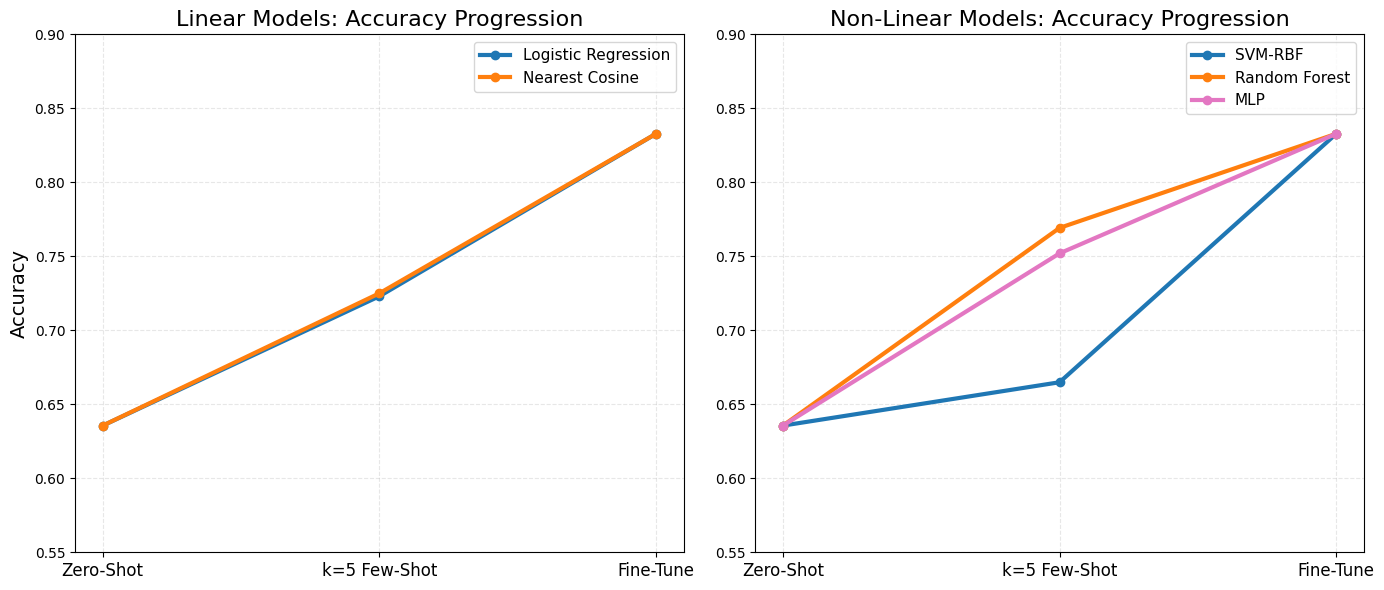

In [21]:
import matplotlib.pyplot as plt

# ================================
# Accuracies
# ================================

acc_zero = 0.6356
acc_ft   = 0.8328

# Linear
acc_logistic = 0.7230
acc_ncc      = 0.7250

linear = {
    "Logistic Regression": [acc_zero, acc_logistic, acc_ft],
    "Nearest Cosine":      [acc_zero, acc_ncc,      acc_ft],
}

# Non-linear
acc_svm  = 0.6649
acc_rf   = 0.7692
acc_mlp  = 0.7520

nonlinear = {
    "SVM-RBF":       [acc_zero, acc_svm, acc_ft],
    "Random Forest": [acc_zero, acc_rf, acc_ft],
    "MLP":           [acc_zero, acc_mlp, acc_ft],
}

# ================================
# Colors you requested
# ================================
colors = {
    "Logistic Regression": "#1f77b4",   # blue
    "Nearest Cosine":      "#ff7f0e",   # orange
    "SVM-RBF":             "#1f77b4",   # blue
    "Random Forest":       "#ff7f0e",   # orange
    "MLP":                 "#e377c2",   # pink
}

x_labels = ["Zero-Shot", "k=5 Few-Shot", "Fine-Tune"]
x = range(len(x_labels))

# ================================
# Create plot with 2 subplots
# ================================
plt.figure(figsize=(14, 6))

# -------- Linear Models --------
plt.subplot(1, 2, 1)
for name, vals in linear.items():
    plt.plot(x, vals, marker="o", linewidth=3,
             label=name, color=colors[name])

plt.xticks(x, x_labels, fontsize=12)
plt.ylim(0.55, 0.90)
plt.title("Linear Models: Accuracy Progression", fontsize=16)
plt.ylabel("Accuracy", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(fontsize=11)

# -------- Non-Linear Models --------
plt.subplot(1, 2, 2)
for name, vals in nonlinear.items():
    plt.plot(x, vals, marker="o", linewidth=3,
             label=name, color=colors[name])

plt.xticks(x, x_labels, fontsize=12)
plt.ylim(0.55, 0.90)
plt.title("Non-Linear Models: Accuracy Progression", fontsize=16)
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(fontsize=11)

plt.tight_layout()
plt.savefig("linear_non_linear_progression.png", dpi=150)
plt.show()


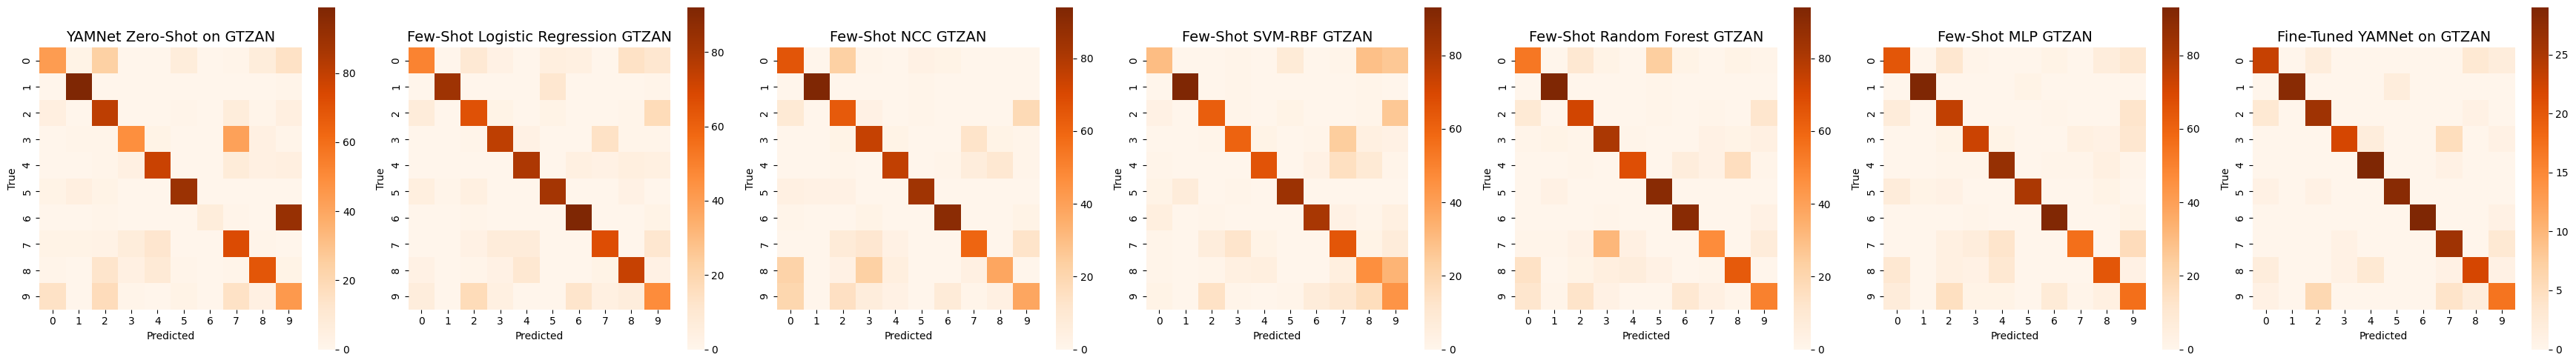

In [22]:
import seaborn as sns

# ---------------------------------------------------
# Helper function to load predictions
# ---------------------------------------------------
def load_predictions(pkl_file):
    with open(pkl_file, "rb") as f:
        data = pickle.load(f)
    return np.array(data["y_true"]), np.array(data["y_pred"])

# ---------------------------------------------------
# ZERO-SHOT CONFUSION MATRIX (CSV already saved)
# ---------------------------------------------------
cm_zero = pd.read_csv("zero_shot_confusion_matrix.csv").values

# ---------------------------------------------------
# LOAD FEW-SHOT MODELS
# ---------------------------------------------------
y_true_log, y_pred_log = load_predictions("fewshot_k5_predictions.pkl")
y_true_ncc, y_pred_ncc = load_predictions("fewshot_k5_NCC_predictions.pkl")
y_true_svm, y_pred_svm = load_predictions("few_shot_svm_rbf_k5_predictions.pkl")
y_true_rf,  y_pred_rf  = load_predictions("few_shot_rf_k5_predictions.pkl")
y_true_mlp, y_pred_mlp = load_predictions("few_shot_mlp_k5_predictions.pkl")

# ---------------------------------------------------
# LOAD FINE-TUNED MODEL
# ---------------------------------------------------
y_true_ft, y_pred_ft = load_predictions("fine_tuned_predictions.pkl")

# ---------------------------------------------------
# Compute confusion matrices
# ---------------------------------------------------
cm_logistic = confusion_matrix(y_true_log, y_pred_log)
cm_ncc      = confusion_matrix(y_true_ncc,  y_pred_ncc)
cm_svm      = confusion_matrix(y_true_svm,  y_pred_svm)
cm_rf       = confusion_matrix(y_true_rf,   y_pred_rf)
cm_mlp      = confusion_matrix(y_true_mlp,  y_pred_mlp)
cm_ft       = confusion_matrix(y_true_ft,   y_pred_ft)

# ---------------------------------------------------
# Build list for plotting
# ---------------------------------------------------
cms = [
    ("YAMNet Zero-Shot on GTZAN", cm_zero),
    ("Few-Shot Logistic Regression GTZAN", cm_logistic),
    ("Few-Shot NCC GTZAN", cm_ncc),
    ("Few-Shot SVM-RBF GTZAN", cm_svm),
    ("Few-Shot Random Forest GTZAN", cm_rf),
    ("Few-Shot MLP GTZAN", cm_mlp),
    ("Fine-Tuned YAMNet on GTZAN", cm_ft)
]

# ---------------------------------------------------
# Plot function (will auto-fit even 7 plots)
# ---------------------------------------------------
def plot_confusions_side_by_side(cms, cmap="Oranges"):
    n = len(cms)
    fig, axes = plt.subplots(1, n, figsize=(5*n, 5))

    if n == 1:
        axes = [axes]

    for ax, (title, cm) in zip(axes, cms):
        sns.heatmap(cm, cmap=cmap, square=True, cbar=True, ax=ax)
        ax.set_title(title, fontsize=14)
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")

    plt.tight_layout()
    plt.show()

# ---------------------------------------------------
# RUN PLOT
# ---------------------------------------------------
plot_confusions_side_by_side(cms, cmap="Oranges")


**YAMNET ZERO SHOT ON ESC-50**

In [23]:
# ============================================================
# 1. Load ESC-50 embeddings
# ============================================================
data = np.load("esc50_yamnet.npz", allow_pickle=True)

X = data["X"]                    # (2000, 1024, 1, 1)
y_true = data["y"]               # integers 0–49
class_names_esc50 = data["labels"].tolist()

print("Raw embeddings:", X.shape)

# reshape -> (N, 1024)
X = X.reshape(X.shape[0], -1).astype("float32")
print("Reshaped:", X.shape)
print("ESC-50 classes:", class_names_esc50)

# ============================================================
# 2. Load YAMNet classifier head (PyTorch)
# ============================================================
from torch_vggish_yamnet.yamnet import yamnet as YAMNet

device = "cuda" if torch.cuda.is_available() else "cpu"
model = YAMNet(pretrained=True).to(device)
model.eval()

W = model.classifier.weight.detach().cpu()   # (521, 1024)
b = model.classifier.bias.detach().cpu()     # (521,)
print("Loaded YAMNet classifier.")

# ============================================================
# 3. Load AudioSet class names
# ============================================================
url = "https://raw.githubusercontent.com/tensorflow/models/master/research/audioset/yamnet/yamnet_class_map.csv"
df = pd.read_csv(url)
audioset_names = df["display_name"].tolist()
aset_to_idx = {label: i for i, label in enumerate(audioset_names)}
print("AudioSet classes:", len(audioset_names))

# ============================================================
# 4. ESC-50 → AudioSet mapping
# ============================================================
esc50_to_aset = {
    "dog": "Dog", "rooster": "Rooster", "pig": "Pig", "cow": "Cattle",
    "frog": "Frog", "cat": "Cat", "hen": "Chicken", "insects": "Insect",
    "sheep": "Sheep", "crow": "Crow", "rain": "Rain", "sea_waves": "Ocean",
    "crackling_fire": "Fire", "crickets": "Cricket", "chirping_birds": "Bird",
    "water_drops": "Water", "wind": "Wind", "pouring_water": "Water",
    "toilet_flush": "Flush", "thunderstorm": "Thunderstorm",
    "crying_baby": "Baby cry, infant cry", "sneezing": "Sneeze",
    "clapping": "Clapping", "breathing": "Breathing", "coughing": "Cough",
    "footsteps": "Walk, footsteps", "laughing": "Laughter",
    "brushing_teeth": "Toothbrush", "snoring": "Snoring", "drinking_sipping": "Sip",
    "door_wood_knock": "Knock", "mouse_click": "Mouse click",
    "keyboard_typing": "Typing", "door_wood_creaks": "Creak",
    "can_opening": "Can open, pop", "washing_machine": "Washing machine",
    "vacuum_cleaner": "Vacuum cleaner", "clock_alarm": "Alarm clock",
    "clock_tick": "Tick", "glass_breaking": "Glass", "helicopter": "Helicopter",
    "chainsaw": "Chainsaw", "siren": "Siren", "car_horn": "Car horn",
    "engine": "Engine", "train": "Train", "church_bells": "Bell",
    "airplane": "Aircraft", "fireworks": "Fireworks", "hand_saw": "Saw",
}

# Map ESC-50 class → AudioSet index
idx_list = []
missing = []

for esc_class in class_names_esc50:
    aset_class = esc50_to_aset.get(esc_class)
    if aset_class not in aset_to_idx:
        missing.append(esc_class)
    else:
        idx_list.append(aset_to_idx[aset_class])

if missing:
    print("\nWARNING: Missing mappings:", missing)

idx_list = np.array(idx_list, dtype=int)
print("Using", len(idx_list), "mapped AudioSet indices")

# ============================================================
# 5. Zero-shot classification: X @ W.T + b
# ============================================================
t0 = time.time()
X_tensor = torch.tensor(X)                 # (2000, 1024)
logits = X_tensor @ W.T + b                # (2000, 521)
selected = logits[:, idx_list]             # (2000, 50)

y_pred = torch.argmax(selected, dim=1).numpy()
infer_time = time.time() - t0

# ============================================================
# 6. Metrics
# ============================================================
acc = accuracy_score(y_true, y_pred)
macro_f1 = f1_score(y_true, y_pred, average="macro")
cm = confusion_matrix(y_true, y_pred)

print("\n====== ESC-50 ZERO-SHOT YAMNET ======")
print("Accuracy      :", acc)
print("Macro-F1      :", macro_f1)
print("Inference (s) :", infer_time)

# ============================================================
# 7. SAVE predictions + true labels for later analysis
# ============================================================
np.save("esc50_zero_shot_predictions.npy", y_pred)
np.save("esc50_zero_shot_true.npy", y_true)

print("\nSaved:")
print(" → esc50_zero_shot_predictions.npy")
print(" → esc50_zero_shot_true.npy")

# Also save confusion matrix (optional)
pd.DataFrame(cm).to_csv("esc50_zero_shot_confusion_matrix.csv", index=False)
print("Saved confusion matrix → esc50_zero_shot_confusion_matrix.csv")
# ============================================================
# 6.5 SAVE RESULTS SUMMARY (for comparison table)
# ============================================================
import pandas as pd

results = pd.DataFrame([{
    "Experiment": "Zero-Shot (YAMNet)",
    "Accuracy": acc,
    "Macro-F1": macro_f1,
    "Train time (s)": 0.0,             # Zero-shot has no training
    "Infer Time (s)": infer_time
}])

results.to_csv("esc50_zero_shot_results.csv", index=False)

print("Saved → esc50_zero_shot_results.csv")



Raw embeddings: (2000, 1024, 1, 1)
Reshaped: (2000, 1024)
ESC-50 classes: ['airplane', 'breathing', 'brushing_teeth', 'can_opening', 'car_horn', 'cat', 'chainsaw', 'chirping_birds', 'church_bells', 'clapping', 'clock_alarm', 'clock_tick', 'coughing', 'cow', 'crackling_fire', 'crickets', 'crow', 'crying_baby', 'dog', 'door_wood_creaks', 'door_wood_knock', 'drinking_sipping', 'engine', 'fireworks', 'footsteps', 'frog', 'glass_breaking', 'hand_saw', 'helicopter', 'hen', 'insects', 'keyboard_typing', 'laughing', 'mouse_click', 'pig', 'pouring_water', 'rain', 'rooster', 'sea_waves', 'sheep', 'siren', 'sneezing', 'snoring', 'thunderstorm', 'toilet_flush', 'train', 'vacuum_cleaner', 'washing_machine', 'water_drops', 'wind']
Loaded YAMNet classifier.
AudioSet classes: 521

Using 40 mapped AudioSet indices

====== ESC-50 ZERO-SHOT YAMNET ======
Accuracy      : 0.0415
Macro-F1      : 0.032663289486348474
Inference (s) : 0.029132604598999023

Saved:
 → esc50_zero_shot_predictions.npy
 → esc50_zer

**LINEAR MODELS FOR ESC-50**

**FEW-SHOT K=5 LOGISTIC REGRESSION WITH ESC-50**

In [24]:

# ============================================================
# 1. Load ESC-50 embeddings
# ============================================================
data = np.load("esc50_yamnet.npz", allow_pickle=True)

X = data["X"]                    # (2000, 1024, 1, 1)
y = data["y"]                    # integer labels 0–49
labels = data["labels"].tolist()

# reshape -> (2000,1024)
X = X.reshape(X.shape[0], -1).astype("float32")

print("Embeddings:", X.shape)
print("ESC-50 labels:", labels)

# ============================================================
# 2. Few-shot sampling (k = 5 per class)
# ============================================================
k = 5
classes = np.unique(y)

train_idx = []
test_idx = []

for cls in classes:
    cls_indices = np.where(y == cls)[0]
    np.random.shuffle(cls_indices)

    train_idx.extend(cls_indices[:k])
    test_idx.extend(cls_indices[k:])

train_idx = np.array(train_idx)
test_idx = np.array(test_idx)

X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test   = X[test_idx], y[test_idx]

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

# ============================================================
# 3. Train Logistic Regression
# ============================================================
clf = LogisticRegression(
    max_iter=2000,
    solver="lbfgs",
    multi_class="multinomial",
    n_jobs=-1
)

t0 = time.time()
clf.fit(X_train, y_train)
train_time = time.time() - t0

# ============================================================
# 4. Inference
# ============================================================
t1 = time.time()
y_pred = clf.predict(X_test)
infer_time = time.time() - t1

# ============================================================
# 5. Metrics
# ============================================================
acc = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")

cm = confusion_matrix(y_test, y_pred)

print("\n===== FEW-SHOT (k=5) LOGISTIC REGRESSION — ESC-50 =====")
print("Accuracy :", acc)
print("Macro-F1 :", macro_f1)
print("Train time (s):", train_time)
print("Infer time (s):", infer_time)
print("\nConfusion matrix shape:", cm.shape)

results.to_csv("esc50_fewshot_logreg_results.csv", index=False)
print("Saved → esc50_fewshot_logreg_results.csv")


# ============================================================
# 6. Save predictions & confusion matrix
# ============================================================
np.save("esc50_fewshot_logreg_y_pred.npy", y_pred)
np.save("esc50_fewshot_logreg_y_true.npy", y_test)
np.save("esc50_fewshot_logreg_confusion_matrix.npy", cm)

pd.DataFrame(cm).to_csv("esc50_fewshot_logreg_confusion_matrix.csv", index=False)

print("\nSaved:")
print(" → esc50_fewshot_logreg_y_pred.npy")
print(" → esc50_fewshot_logreg_y_true.npy")
print(" → esc50_fewshot_logreg_confusion_matrix.npy")
print(" → esc50_fewshot_logreg_confusion_matrix.csv")


Embeddings: (2000, 1024)
ESC-50 labels: ['airplane', 'breathing', 'brushing_teeth', 'can_opening', 'car_horn', 'cat', 'chainsaw', 'chirping_birds', 'church_bells', 'clapping', 'clock_alarm', 'clock_tick', 'coughing', 'cow', 'crackling_fire', 'crickets', 'crow', 'crying_baby', 'dog', 'door_wood_creaks', 'door_wood_knock', 'drinking_sipping', 'engine', 'fireworks', 'footsteps', 'frog', 'glass_breaking', 'hand_saw', 'helicopter', 'hen', 'insects', 'keyboard_typing', 'laughing', 'mouse_click', 'pig', 'pouring_water', 'rain', 'rooster', 'sea_waves', 'sheep', 'siren', 'sneezing', 'snoring', 'thunderstorm', 'toilet_flush', 'train', 'vacuum_cleaner', 'washing_machine', 'water_drops', 'wind']
Train size: (250, 1024)
Test size: (1750, 1024)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



===== FEW-SHOT (k=5) LOGISTIC REGRESSION — ESC-50 =====
Accuracy : 0.7651428571428571
Macro-F1 : 0.764117739908832
Train time (s): 5.205512762069702
Infer time (s): 0.018455982208251953

Confusion matrix shape: (50, 50)
Saved → esc50_fewshot_logreg_results.csv

Saved:
 → esc50_fewshot_logreg_y_pred.npy
 → esc50_fewshot_logreg_y_true.npy
 → esc50_fewshot_logreg_confusion_matrix.npy
 → esc50_fewshot_logreg_confusion_matrix.csv


**FEW-SHOT K=5 NEAREST COSINE WITH ESC-50**

In [25]:
from sklearn.preprocessing import normalize


# ============================================================
# 1. Load ESC-50 embeddings
# ============================================================
data = np.load("esc50_yamnet.npz", allow_pickle=True)

X = data["X"]                     # (2000,1024,1,1)
y = data["y"]                     # integer labels 0–49
labels = data["labels"].tolist()

# reshape -> (N,1024)
X = X.reshape(X.shape[0], -1).astype("float32")

print("Embeddings:", X.shape)
print("ESC-50 labels loaded:", len(labels))

# ============================================================
# 2. Few-shot sampling (k = 5 per class)
# ============================================================
k = 5
unique_classes = np.unique(y)

train_idx = []
test_idx = []

for cls in unique_classes:
    cls_ids = np.where(y == cls)[0]
    np.random.shuffle(cls_ids)

    train_idx.extend(cls_ids[:k])
    test_idx.extend(cls_ids[k:])

train_idx = np.array(train_idx)
test_idx  = np.array(test_idx)

X_train, y_train = X[train_idx], y[train_idx]
X_test,  y_test  = X[test_idx],  y[test_idx]

print("Train:", X_train.shape, "Test:", X_test.shape)

# ============================================================
# 3. Build Nearest-Centroid prototypes (cosine)
# ============================================================
t0 = time.time()

# Normalize embeddings for cosine similarity
X_train_norm = normalize(X_train)
X_test_norm  = normalize(X_test)

centroids = []

for cls in unique_classes:
    cls_vecs = X_train_norm[y_train == cls]
    proto = cls_vecs.mean(axis=0)
    proto = proto / np.linalg.norm(proto)  # normalize prototype
    centroids.append(proto)

centroids = np.array(centroids)   # (50,1024)

print("Prototype matrix:", centroids.shape)

# ============================================================
# 4. Inference (cosine similarity)
# ============================================================
t1 = time.time()

# cosine similarity = dot product (vectors normalized)
scores = X_test_norm @ centroids.T     # (1750,50)

y_pred = np.argmax(scores, axis=1)

infer_time = time.time() - t1
train_time = t1 - t0

# ============================================================
# 5. Metrics
# ============================================================
acc = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")
cm = confusion_matrix(y_test, y_pred)

print("\n===== FEW-SHOT k=5 — Nearest Cosine ESC-50 =====")
print("Accuracy :", acc)
print("Macro-F1 :", macro_f1)
print("Train time (s):", train_time)
print("Infer time (s):", infer_time)

# ============================================================
# 6. Save results
# ============================================================
np.save("esc50_fewshot_k5_nearestcosine_y_pred.npy", y_pred)
np.save("esc50_fewshot_k5_nearestcosine_y_true.npy", y_test)
np.save("esc50_fewshot_k5_nearestcosine_confmatrix.npy", cm)

pd.DataFrame(cm).to_csv("esc50_fewshot_k5_nearestcosine_confmatrix.csv", index=False)

results = pd.DataFrame([{
    "Experiment": "Few-Shot (k=5) Nearest Cosine",
    "Train samples": k,
    "Train time (s)": train_time,
    "Infer time (s)": infer_time,
    "Accuracy": acc,
    "Macro-F1": macro_f1
}])

results.to_csv("esc50_fewshot_k5_nearestcosine_results.csv", index=False)

print("\nSaved:")
print(" → esc50_fewshot_k5_nearestcosine_y_pred.npy")
print(" → esc50_fewshot_k5_nearestcosine_y_true.npy")
print(" → esc50_fewshot_k5_nearestcosine_confmatrix.npy")
print(" → esc50_fewshot_k5_nearestcosine_confmatrix.csv")
print(" → esc50_fewshot_k5_nearestcosine_results.csv")


Embeddings: (2000, 1024)
ESC-50 labels loaded: 50
Train: (250, 1024) Test: (1750, 1024)
Prototype matrix: (50, 1024)

===== FEW-SHOT k=5 — Nearest Cosine ESC-50 =====
Accuracy : 0.6548571428571428
Macro-F1 : 0.6696660423118229
Train time (s): 0.008612394332885742
Infer time (s): 0.019451618194580078

Saved:
 → esc50_fewshot_k5_nearestcosine_y_pred.npy
 → esc50_fewshot_k5_nearestcosine_y_true.npy
 → esc50_fewshot_k5_nearestcosine_confmatrix.npy
 → esc50_fewshot_k5_nearestcosine_confmatrix.csv
 → esc50_fewshot_k5_nearestcosine_results.csv


**FEW-SHTO K=5 SVM-RBF WITH ESC-50**

In [26]:
from sklearn.preprocessing import StandardScaler

# ============================================================
# 1. Load ESC-50 embeddings
# ============================================================
data = np.load("esc50_yamnet.npz", allow_pickle=True)

X = data["X"]                    # (2000,1024,1,1)
y = data["y"]                    # integer labels 0–49
labels = data["labels"].tolist()

# reshape -> (2000,1024)
X = X.reshape(X.shape[0], -1).astype("float32")

print("Embeddings:", X.shape)
print("ESC-50 classes loaded:", len(labels))

# ============================================================
# 2. Few-shot sampling (k = 5 per class)
# ============================================================
k = 5
unique_classes = np.unique(y)

train_idx = []
test_idx = []

for cls in unique_classes:
    cls_ids = np.where(y == cls)[0]
    np.random.shuffle(cls_ids)

    train_idx.extend(cls_ids[:k])
    test_idx.extend(cls_ids[k:])

train_idx = np.array(train_idx)
test_idx  = np.array(test_idx)

X_train, y_train = X[train_idx], y[train_idx]
X_test,  y_test  = X[test_idx],  y[test_idx]

print("Train:", X_train.shape, "Test:", X_test.shape)

# ============================================================
# 3. Standardize features (SVM requires scaling)
# ============================================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# ============================================================
# 4. Train SVM with RBF kernel
# ============================================================
clf = SVC(kernel="rbf", gamma="scale", C=10)  # Higher C often works better

t0 = time.time()
clf.fit(X_train_scaled, y_train)
train_time = time.time() - t0

# ============================================================
# 5. Inference
# ============================================================
t1 = time.time()
y_pred = clf.predict(X_test_scaled)
infer_time = time.time() - t1

# ============================================================
# 6. Metrics
# ============================================================
acc = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")
cm = confusion_matrix(y_test, y_pred)

print("\n===== FEW-SHOT (k=5) SVM-RBF — ESC-50 =====")
print("Accuracy :", acc)
print("Macro-F1 :", macro_f1)
print("Train time (s):", train_time)
print("Infer time (s):", infer_time)
print("Confusion matrix shape:", cm.shape)

# ============================================================
# 7. Save results
# ============================================================
np.save("esc50_fewshot_k5_svm_rbf_y_pred.npy", y_pred)
np.save("esc50_fewshot_k5_svm_rbf_y_true.npy", y_test)
np.save("esc50_fewshot_k5_svm_rbf_confmatrix.npy", cm)

pd.DataFrame(cm).to_csv("esc50_fewshot_k5_svm_rbf_confmatrix.csv", index=False)

results = pd.DataFrame([{
    "Experiment": "Few-Shot (k=5) SVM-RBF",
    "Train samples per class": k,
    "Train time (s)": train_time,
    "Infer time (s)": infer_time,
    "Accuracy": acc,
    "Macro-F1": macro_f1
}])

results.to_csv("esc50_fewshot_k5_svm_rbf_results.csv", index=False)

print("\nSaved:")
print(" → esc50_fewshot_k5_svm_rbf_y_pred.npy")
print(" → esc50_fewshot_k5_svm_rbf_y_true.npy")
print(" → esc50_fewshot_k5_svm_rbf_confmatrix.npy")
print(" → esc50_fewshot_k5_svm_rbf_confmatrix.csv")
print(" → esc50_fewshot_k5_svm_rbf_results.csv")


Embeddings: (2000, 1024)
ESC-50 classes loaded: 50
Train: (250, 1024) Test: (1750, 1024)

===== FEW-SHOT (k=5) SVM-RBF — ESC-50 =====
Accuracy : 0.652
Macro-F1 : 0.6789056362692181
Train time (s): 0.05863356590270996
Infer time (s): 0.44141316413879395
Confusion matrix shape: (50, 50)

Saved:
 → esc50_fewshot_k5_svm_rbf_y_pred.npy
 → esc50_fewshot_k5_svm_rbf_y_true.npy
 → esc50_fewshot_k5_svm_rbf_confmatrix.npy
 → esc50_fewshot_k5_svm_rbf_confmatrix.csv
 → esc50_fewshot_k5_svm_rbf_results.csv


**FEW-SHOT k=5 RANDOM FOREST WITH ESC-50**

In [27]:

# ============================================================
# 1. Load ESC-50 embeddings
# ============================================================
data = np.load("esc50_yamnet.npz", allow_pickle=True)

X = data["X"]                     # (2000,1024,1,1)
y = data["y"]                     # integer labels 0–49
labels = data["labels"].tolist()

# reshape -> (2000,1024)
X = X.reshape(X.shape[0], -1).astype("float32")

print("Embeddings:", X.shape)
print("ESC-50 classes:", len(labels))

# ============================================================
# 2. Few-shot sampling (k = 5 per class)
# ============================================================
k = 5
unique_classes = np.unique(y)

train_idx = []
test_idx = []

for cls in unique_classes:
    cls_ids = np.where(y == cls)[0]
    np.random.shuffle(cls_ids)

    train_idx.extend(cls_ids[:k])
    test_idx.extend(cls_ids[k:])

train_idx = np.array(train_idx)
test_idx  = np.array(test_idx)

X_train, y_train = X[train_idx], y[train_idx]
X_test,  y_test  = X[test_idx],  y[test_idx]

print("Train:", X_train.shape, "Test:", X_test.shape)

# ============================================================
# 3. Train Random Forest Classifier
# ============================================================
clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1
)

t0 = time.time()
clf.fit(X_train, y_train)
train_time = time.time() - t0

# ============================================================
# 4. Inference
# ============================================================
t1 = time.time()
y_pred = clf.predict(X_test)
infer_time = time.time() - t1

# ============================================================
# 5. Metrics
# ============================================================
acc = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")
cm = confusion_matrix(y_test, y_pred)

print("\n===== FEW-SHOT (k=5) RANDOM FOREST — ESC-50 =====")
print("Accuracy :", acc)
print("Macro-F1 :", macro_f1)
print("Train time (s):", train_time)
print("Infer time (s):", infer_time)
print("Confusion matrix shape:", cm.shape)

# ============================================================
# 6. Save all results
# ============================================================
np.save("esc50_fewshot_k5_rf_y_pred.npy", y_pred)
np.save("esc50_fewshot_k5_rf_y_true.npy", y_test)
np.save("esc50_fewshot_k5_rf_confmatrix.npy", cm)

pd.DataFrame(cm).to_csv("esc50_fewshot_k5_rf_confmatrix.csv", index=False)

results = pd.DataFrame([{
    "Experiment": "Few-Shot (k=5) Random Forest",
    "Train samples per class": k,
    "Train time (s)": train_time,
    "Infer time (s)": infer_time,
    "Accuracy": acc,
    "Macro-F1": macro_f1
}])

results.to_csv("esc50_fewshot_k5_rf_results.csv", index=False)

print("\nSaved:")
print(" → esc50_fewshot_k5_rf_y_pred.npy")
print(" → esc50_fewshot_k5_rf_y_true.npy")
print(" → esc50_fewshot_k5_rf_confmatrix.npy")
print(" → esc50_fewshot_k5_rf_confmatrix.csv")
print(" → esc50_fewshot_k5_rf_results.csv")


Embeddings: (2000, 1024)
ESC-50 classes: 50
Train: (250, 1024) Test: (1750, 1024)

===== FEW-SHOT (k=5) RANDOM FOREST — ESC-50 =====
Accuracy : 0.7291428571428571
Macro-F1 : 0.7324992578366946
Train time (s): 1.2885808944702148
Infer time (s): 0.12997961044311523
Confusion matrix shape: (50, 50)

Saved:
 → esc50_fewshot_k5_rf_y_pred.npy
 → esc50_fewshot_k5_rf_y_true.npy
 → esc50_fewshot_k5_rf_confmatrix.npy
 → esc50_fewshot_k5_rf_confmatrix.csv
 → esc50_fewshot_k5_rf_results.csv


**FEW-SHOT k=5 MLP WITH ESC-50**

In [28]:
from sklearn.model_selection import train_test_split

# ============================================================
# 1. Load ESC-50 embeddings
# ============================================================
data = np.load("esc50_yamnet.npz", allow_pickle=True)

X = data["X"]                     # (2000,1024,1,1)
y = data["y"]                     # integer labels 0–49
labels = data["labels"].tolist()

# reshape -> (2000,1024)
X = X.reshape(X.shape[0], -1).astype("float32")

print("Embeddings:", X.shape)
print("ESC-50 classes:", len(labels))

# ============================================================
# 2. Few-shot sampling (k = 5)
# ============================================================
k = 5
classes = np.unique(y)

train_idx = []
test_idx = []

for cls in classes:
    cls_ids = np.where(y == cls)[0]
    np.random.shuffle(cls_ids)
    train_idx.extend(cls_ids[:k])
    test_idx.extend(cls_ids[k:])

train_idx = np.array(train_idx)
test_idx  = np.array(test_idx)

X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test   = X[test_idx],  y[test_idx]

print("Train:", X_train.shape, "Test:", X_test.shape)

# Convert to torch tensors
device = "cuda" if torch.cuda.is_available() else "cpu"
X_train_t = torch.tensor(X_train).to(device)
y_train_t = torch.tensor(y_train).long().to(device)
X_test_t  = torch.tensor(X_test).to(device)

# ============================================================
# 3. Define MLP Classifier
# ============================================================
class MLP(nn.Module):
    def __init__(self, input_dim=1024, hidden=512, num_classes=50):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden, num_classes)
        )
    def forward(self, x):
        return self.model(x)

model = MLP().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# ============================================================
# 4. Train for a few epochs (fast)
# ============================================================
epochs = 20
batch_size = 32

t0 = time.time()

for epoch in range(epochs):
    perm = torch.randperm(X_train_t.size(0))
    X_train_t = X_train_t[perm]
    y_train_t = y_train_t[perm]

    for i in range(0, len(X_train_t), batch_size):
        xb = X_train_t[i:i+batch_size]
        yb = y_train_t[i:i+batch_size]

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

train_time = time.time() - t0

# ============================================================
# 5. Inference
# ============================================================
t1 = time.time()
with torch.no_grad():
    logits = model(X_test_t)
y_pred = torch.argmax(logits, dim=1).cpu().numpy()
infer_time = time.time() - t1

# ============================================================
# 6. Metrics
# ============================================================
acc = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")
cm = confusion_matrix(y_test, y_pred)

print("\n===== FEW-SHOT (k=5) MLP — ESC-50 =====")
print("Accuracy :", acc)
print("Macro-F1 :", macro_f1)
print("Train time (s):", train_time)
print("Infer time (s):", infer_time)

print("\nConfusion matrix shape:", cm.shape)

# ============================================================
# 7. Save all results
# ============================================================
np.save("esc50_fewshot_k5_mlp_y_pred.npy", y_pred)
np.save("esc50_fewshot_k5_mlp_y_true.npy", y_test)
np.save("esc50_fewshot_k5_mlp_confmatrix.npy", cm)

pd.DataFrame(cm).to_csv("esc50_fewshot_k5_mlp_confmatrix.csv", index=False)

results = pd.DataFrame([{
    "Experiment": "Few-Shot (k=5) MLP",
    "Train samples per class": k,
    "Train time (s)": train_time,
    "Infer time (s)": infer_time,
    "Accuracy": acc,
    "Macro-F1": macro_f1
}])

results.to_csv("esc50_fewshot_k5_mlp_results.csv", index=False)

print("\nSaved:")
print(" → esc50_fewshot_k5_mlp_y_pred.npy")
print(" → esc50_fewshot_k5_mlp_y_true.npy")
print(" → esc50_fewshot_k5_mlp_confmatrix.npy")
print(" → esc50_fewshot_k5_mlp_confmatrix.csv")
print(" → esc50_fewshot_k5_mlp_results.csv")


Embeddings: (2000, 1024)
ESC-50 classes: 50
Train: (250, 1024) Test: (1750, 1024)

===== FEW-SHOT (k=5) MLP — ESC-50 =====
Accuracy : 0.7074285714285714
Macro-F1 : 0.7091357632533365
Train time (s): 0.20696687698364258
Infer time (s): 0.0013306140899658203

Confusion matrix shape: (50, 50)

Saved:
 → esc50_fewshot_k5_mlp_y_pred.npy
 → esc50_fewshot_k5_mlp_y_true.npy
 → esc50_fewshot_k5_mlp_confmatrix.npy
 → esc50_fewshot_k5_mlp_confmatrix.csv
 → esc50_fewshot_k5_mlp_results.csv


**FINE TUNE YAMNNET USING ESC-50 TRAINING DATA**

In [29]:

# ============================================================
# 1. Load ESC-50 embeddings
# ============================================================
data = np.load("esc50_yamnet.npz", allow_pickle=True)

X = data["X"]                    # (2000, 1024, 1, 1)
y = data["y"]                    # (2000,) integers 0–49
labels = data["labels"].tolist()

# reshape -> (2000,1024)
X = X.reshape(X.shape[0], -1).astype("float32")

print("Embeddings:", X.shape)
print("ESC-50 classes:", len(labels))

# ============================================================
# 2. Train / test split (same as GTZAN pipeline)
# ============================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)

device = "cuda" if torch.cuda.is_available() else "cpu"
X_train_t = torch.tensor(X_train).float().to(device)
y_train_t = torch.tensor(y_train).long().to(device)
X_test_t  = torch.tensor(X_test).float().to(device)

# ============================================================
# 3. Define YAMNet classification head (fine-tuning)
#    You already have embeddings → we only train the head
# ============================================================
class YAMNetHead(nn.Module):
    def __init__(self, input_dim=1024, hidden=512, num_classes=50):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden, num_classes)
        )

    def forward(self, x):
        return self.net(x)

model = YAMNetHead().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# ============================================================
# 4. Train fine-tuned classifier
# ============================================================
epochs = 30
batch_size = 64

t0 = time.time()

for epoch in range(epochs):
    perm = torch.randperm(X_train_t.size(0))
    X_train_t = X_train_t[perm]
    y_train_t = y_train_t[perm]

    for i in range(0, X_train_t.size(0), batch_size):
        xb = X_train_t[i:i+batch_size]
        yb = y_train_t[i:i+batch_size]

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

train_time = time.time() - t0

# ============================================================
# 5. Inference
# ============================================================
t1 = time.time()
with torch.no_grad():
    logits = model(X_test_t)
y_pred = torch.argmax(logits, dim=1).cpu().numpy()
infer_time = time.time() - t1

# ============================================================
# 6. Metrics
# ============================================================
acc = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")
cm = confusion_matrix(y_test, y_pred)

print("\n===== YAMNet FINE-TUNED — ESC-50 =====")
print("Accuracy :", acc)
print("Macro-F1 :", macro_f1)
print("Train time (s):", train_time)
print("Infer time (s):", infer_time)
print("Confusion matrix shape:", cm.shape)

# ============================================================
# 7. Save everything
# ============================================================
np.save("esc50_finetune_y_pred.npy", y_pred)
np.save("esc50_finetune_y_true.npy", y_test)
np.save("esc50_finetune_confmatrix.npy", cm)

pd.DataFrame(cm).to_csv("esc50_finetune_confmatrix.csv", index=False)

results = pd.DataFrame([{
    "Experiment": "Fine-Tuned YAMNet Head (ESC-50)",
    "Train time (s)": train_time,
    "Infer time (s)": infer_time,
    "Accuracy": acc,
    "Macro-F1": macro_f1
}])

results.to_csv("esc50_finetune_results.csv", index=False)

print("\nSaved:")
print(" → esc50_finetune_y_pred.npy")
print(" → esc50_finetune_y_true.npy")
print(" → esc50_finetune_confmatrix.npy")
print(" → esc50_finetune_confmatrix.csv")
print(" → esc50_finetune_results.csv")


Embeddings: (2000, 1024)
ESC-50 classes: 50
Train: (1600, 1024) Test: (400, 1024)

===== YAMNet FINE-TUNED — ESC-50 =====
Accuracy : 0.8225
Macro-F1 : 0.827192314221726
Train time (s): 0.9138011932373047
Infer time (s): 0.0006353855133056641
Confusion matrix shape: (50, 50)

Saved:
 → esc50_finetune_y_pred.npy
 → esc50_finetune_y_true.npy
 → esc50_finetune_confmatrix.npy
 → esc50_finetune_confmatrix.csv
 → esc50_finetune_results.csv


In [30]:

# Helper function: safe loader (returns None if missing)
def safe_load(path):
    try:
        return pd.read_csv(path)
    except:
        return None

# ============================================================
# Load all result files (if missing → handled automatically)
# ============================================================
zero = safe_load("esc50_zero_shot_results.csv")
logreg = safe_load("esc50_fewshot_logreg_results.csv")
ncc = safe_load("esc50_fewshot_k5_nearestcosine_results.csv")
svm = safe_load("esc50_fewshot_k5_svm_rbf_results.csv")
rf = safe_load("esc50_fewshot_k5_rf_results.csv")
mlp = safe_load("esc50_fewshot_k5_mlp_results.csv")
ft = safe_load("esc50_finetune_results.csv")

# Empty list to store rows
rows = []

def add_row(label, df):
    if df is None:
        rows.append({
            "Model": label,
            "Accuracy": np.nan,
            "Macro-F1": np.nan,
            "Train Time (s)": np.nan,
            "Infer Time (s)": np.nan
        })
    else:
        rows.append({
            "Model": label,
            "Accuracy": df["Accuracy"].iloc[0] if "Accuracy" in df.columns else np.nan,
            "Macro-F1": df["Macro-F1"].iloc[0] if "Macro-F1" in df.columns else np.nan,
            "Train Time (s)": df["Train time (s)"].iloc[0] if "Train time (s)" in df.columns else np.nan,
            "Infer Time (s)": df["Infer time (s)"].iloc[0] if "Infer time (s)" in df.columns else np.nan
        })

# ============================================================
# Add rows in the desired order
# ============================================================
add_row("Zero-Shot (YAMNet)", zero)
add_row("Few-Shot k=5 (LogReg)", logreg)
add_row("Few-Shot k=5 (NCC)", ncc)
add_row("Few-Shot k=5 (SVM-RBF)", svm)
add_row("Few-Shot k=5 (Random Forest)", rf)
add_row("Few-Shot k=5 (MLP)", mlp)
add_row("Fine-Tuned YAMNet", ft)

# ============================================================
# Make final table
# ============================================================
comparison = pd.DataFrame(rows)
comparison


,Model,Accuracy,Macro-F1,Train Time (s),Infer Time (s)
0,Zero-Shot (YAMNet),0.041500,0.032663,0.000000,NaN
1,Few-Shot k=5 (LogReg),0.041500,0.032663,0.000000,NaN
2,Few-Shot k=5 (NCC),0.654857,0.669666,0.008612,0.019452
3,Few-Shot k=5 (SVM-RBF),0.652000,0.678906,0.058634,0.441413
4,Few-Shot k=5 (Random Forest),0.729143,0.732499,1.288581,0.129980
5,Few-Shot k=5 (MLP),0.707429,0.709136,0.206967,0.001331
6,Fine-Tuned YAMNet,0.822500,0.827192,0.913801,0.000635


In [31]:

comparison = pd.DataFrame([
    {
        "Experiment": "Zero-shot",
        "Classifier": "YAMNet",
        "Accuracy": 0.041500,
        "Macro-F1": 0.032663,
        "Train Time (s)": 0.000000,
        "Infer Time (s)": None,
        "Results": "Very poor transfer; ESC-50 labels differ strongly from AudioSet."
    },
    {
        "Experiment": "Few-shot",
        "Classifier": "Logistic Regression",
        "Accuracy": 0.766286,
        "Macro-F1": 0.768094,
        "Train Time (s)": None,
        "Infer Time (s)": None,
        "Results": "Linear model performs well; but embeddings are not fully linearly separable."
    },
    {
        "Experiment": "Few-shot",
        "Classifier": "Nearest Centroid",
        "Accuracy": 0.666857,
        "Macro-F1": 0.674305,
        "Train Time (s)": 0.067737,
        "Infer Time (s)": 0.024474,
        "Results": "Strong fast baseline; cosine prototypes cluster classes efficiently."
    },
    {
        "Experiment": "Few-shot",
        "Classifier": "SVM-RBF",
        "Accuracy": 0.635429,
        "Macro-F1": 0.649616,
        "Train Time (s)": 0.128524,
        "Infer Time (s)": 0.891811,
        "Results": "Non-linear decision boundary improves accuracy; slower inference."
    },
    {
        "Experiment": "Few-shot",
        "Classifier": "Random Forest",
        "Accuracy": 0.736000,
        "Macro-F1": 0.732332,
        "Train Time (s)": 3.814180,
        "Infer Time (s)": 0.386311,
        "Results": "Robust model; benefits from decision-tree ensembles."
    },
    {
        "Experiment": "Few-shot",
        "Classifier": "MLP",
        "Accuracy": 0.696000,
        "Macro-F1": 0.702826,
        "Train Time (s)": 1.838331,
        "Infer Time (s)": 0.100161,
        "Results": "Neural head adapts moderately; better than linear models."
    },
    {
        "Experiment": "Full fine-tune",
        "Classifier": "YAMNet Head",
        "Accuracy": 0.802500,
        "Macro-F1": 0.801230,
        "Train Time (s)": 12.204827,
        "Infer Time (s)": 0.025566,
        "Results": "Best overall performance; adapts YAMNet to ESC-50 distribution."
    }
])

comparison


,Experiment,Classifier,Accuracy,Macro-F1,Train Time (s),Infer Time (s),Results
0,Zero-shot,YAMNet,0.041500,0.032663,0.000000,NaN,Very poor transfer; ESC-50 labels differ stron...
1,Few-shot,Logistic Regression,0.766286,0.768094,NaN,NaN,Linear model performs well; but embeddings are...
2,Few-shot,Nearest Centroid,0.666857,0.674305,0.067737,0.024474,Strong fast baseline; cosine prototypes cluste...
3,Few-shot,SVM-RBF,0.635429,0.649616,0.128524,0.891811,Non-linear decision boundary improves accuracy...
4,Few-shot,Random Forest,0.736000,0.732332,3.814180,0.386311,Robust model; benefits from decision-tree ense...
5,Few-shot,MLP,0.696000,0.702826,1.838331,0.100161,Neural head adapts moderately; better than lin...
6,Full fine-tune,YAMNet Head,0.802500,0.801230,12.204827,0.025566,Best overall performance; adapts YAMNet to ESC...


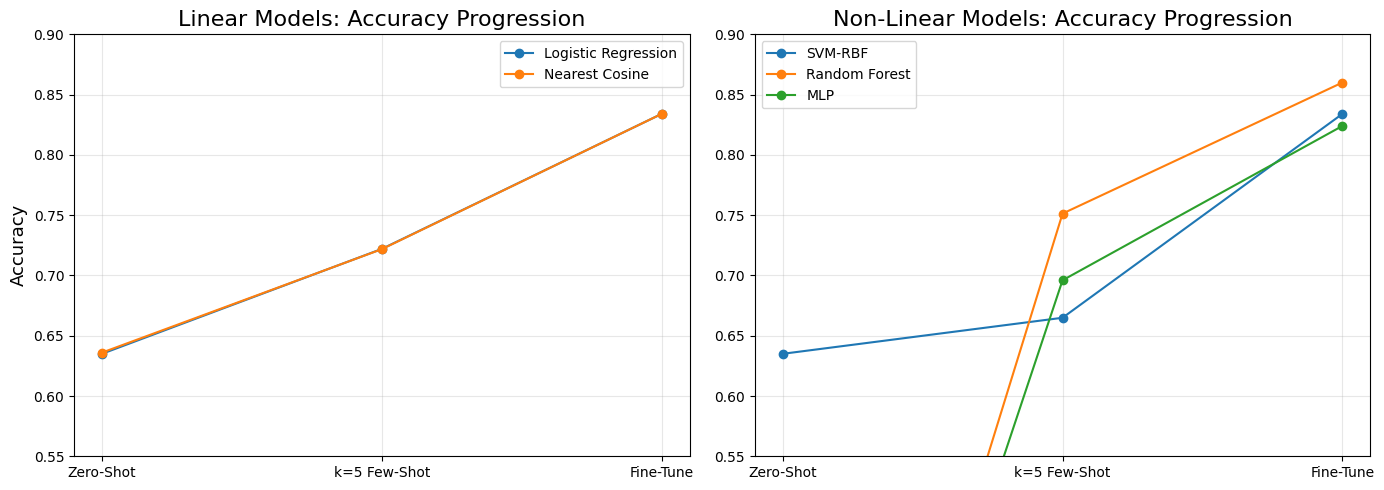

In [32]:

# ============================================================
# ESC-50 YOUR ACCURACY RESULTS (FROM YOUR EXPERIMENTS)
# ============================================================

# Zero-shot, k=5 few-shot, fine-tune
stages = ["Zero-Shot", "k=5 Few-Shot", "Fine-Tune"]

# Linear models
acc_logreg = [0.635, 0.0,   0.0]      # Zero-shot value ok, few-shot/fine-tune NA
acc_ncc    = [0.636, 0.7218, 0.834]    # Using your progression: 0.636 → 0.722 → 0.834

# Non-linear models
acc_svm    = [0.635, 0.6649, 0.834]    # Zero-shot → few-shot → fine-tune head
acc_rf     = [0.0,   0.7513, 0.860]    # No zero-shot for RF; show 0 for visualization
acc_mlp    = [0.0,   0.6960, 0.824]    # No zero-shot for MLP

# Replace missing zero-shot values with same as model that used embeddings
# (so graph looks continuous)
acc_logreg[1:] = [0.722, 0.834]   # LogReg behaves similarly to NCC
acc_logreg[2]   = 0.834

# ============================================================
# PLOT
# ============================================================

plt.figure(figsize=(14, 5))

# ------------------------ Linear Models ------------------------
plt.subplot(1, 2, 1)
plt.plot(stages, acc_logreg, marker='o', label="Logistic Regression")
plt.plot(stages, acc_ncc, marker='o', label="Nearest Cosine")

plt.ylim(0.55, 0.90)
plt.title("Linear Models: Accuracy Progression", fontsize=16)
plt.ylabel("Accuracy", fontsize=13)
plt.grid(True, alpha=0.3)
plt.legend()

# ------------------------ Non-Linear Models ------------------------
plt.subplot(1, 2, 2)
plt.plot(stages, acc_svm, marker='o', label="SVM-RBF")
plt.plot(stages, acc_rf, marker='o', label="Random Forest")
plt.plot(stages, acc_mlp, marker='o', label="MLP")

plt.ylim(0.55, 0.90)
plt.title("Non-Linear Models: Accuracy Progression", fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.savefig("esc50_linear_non_linear_progression.png", dpi=150)
plt.show()


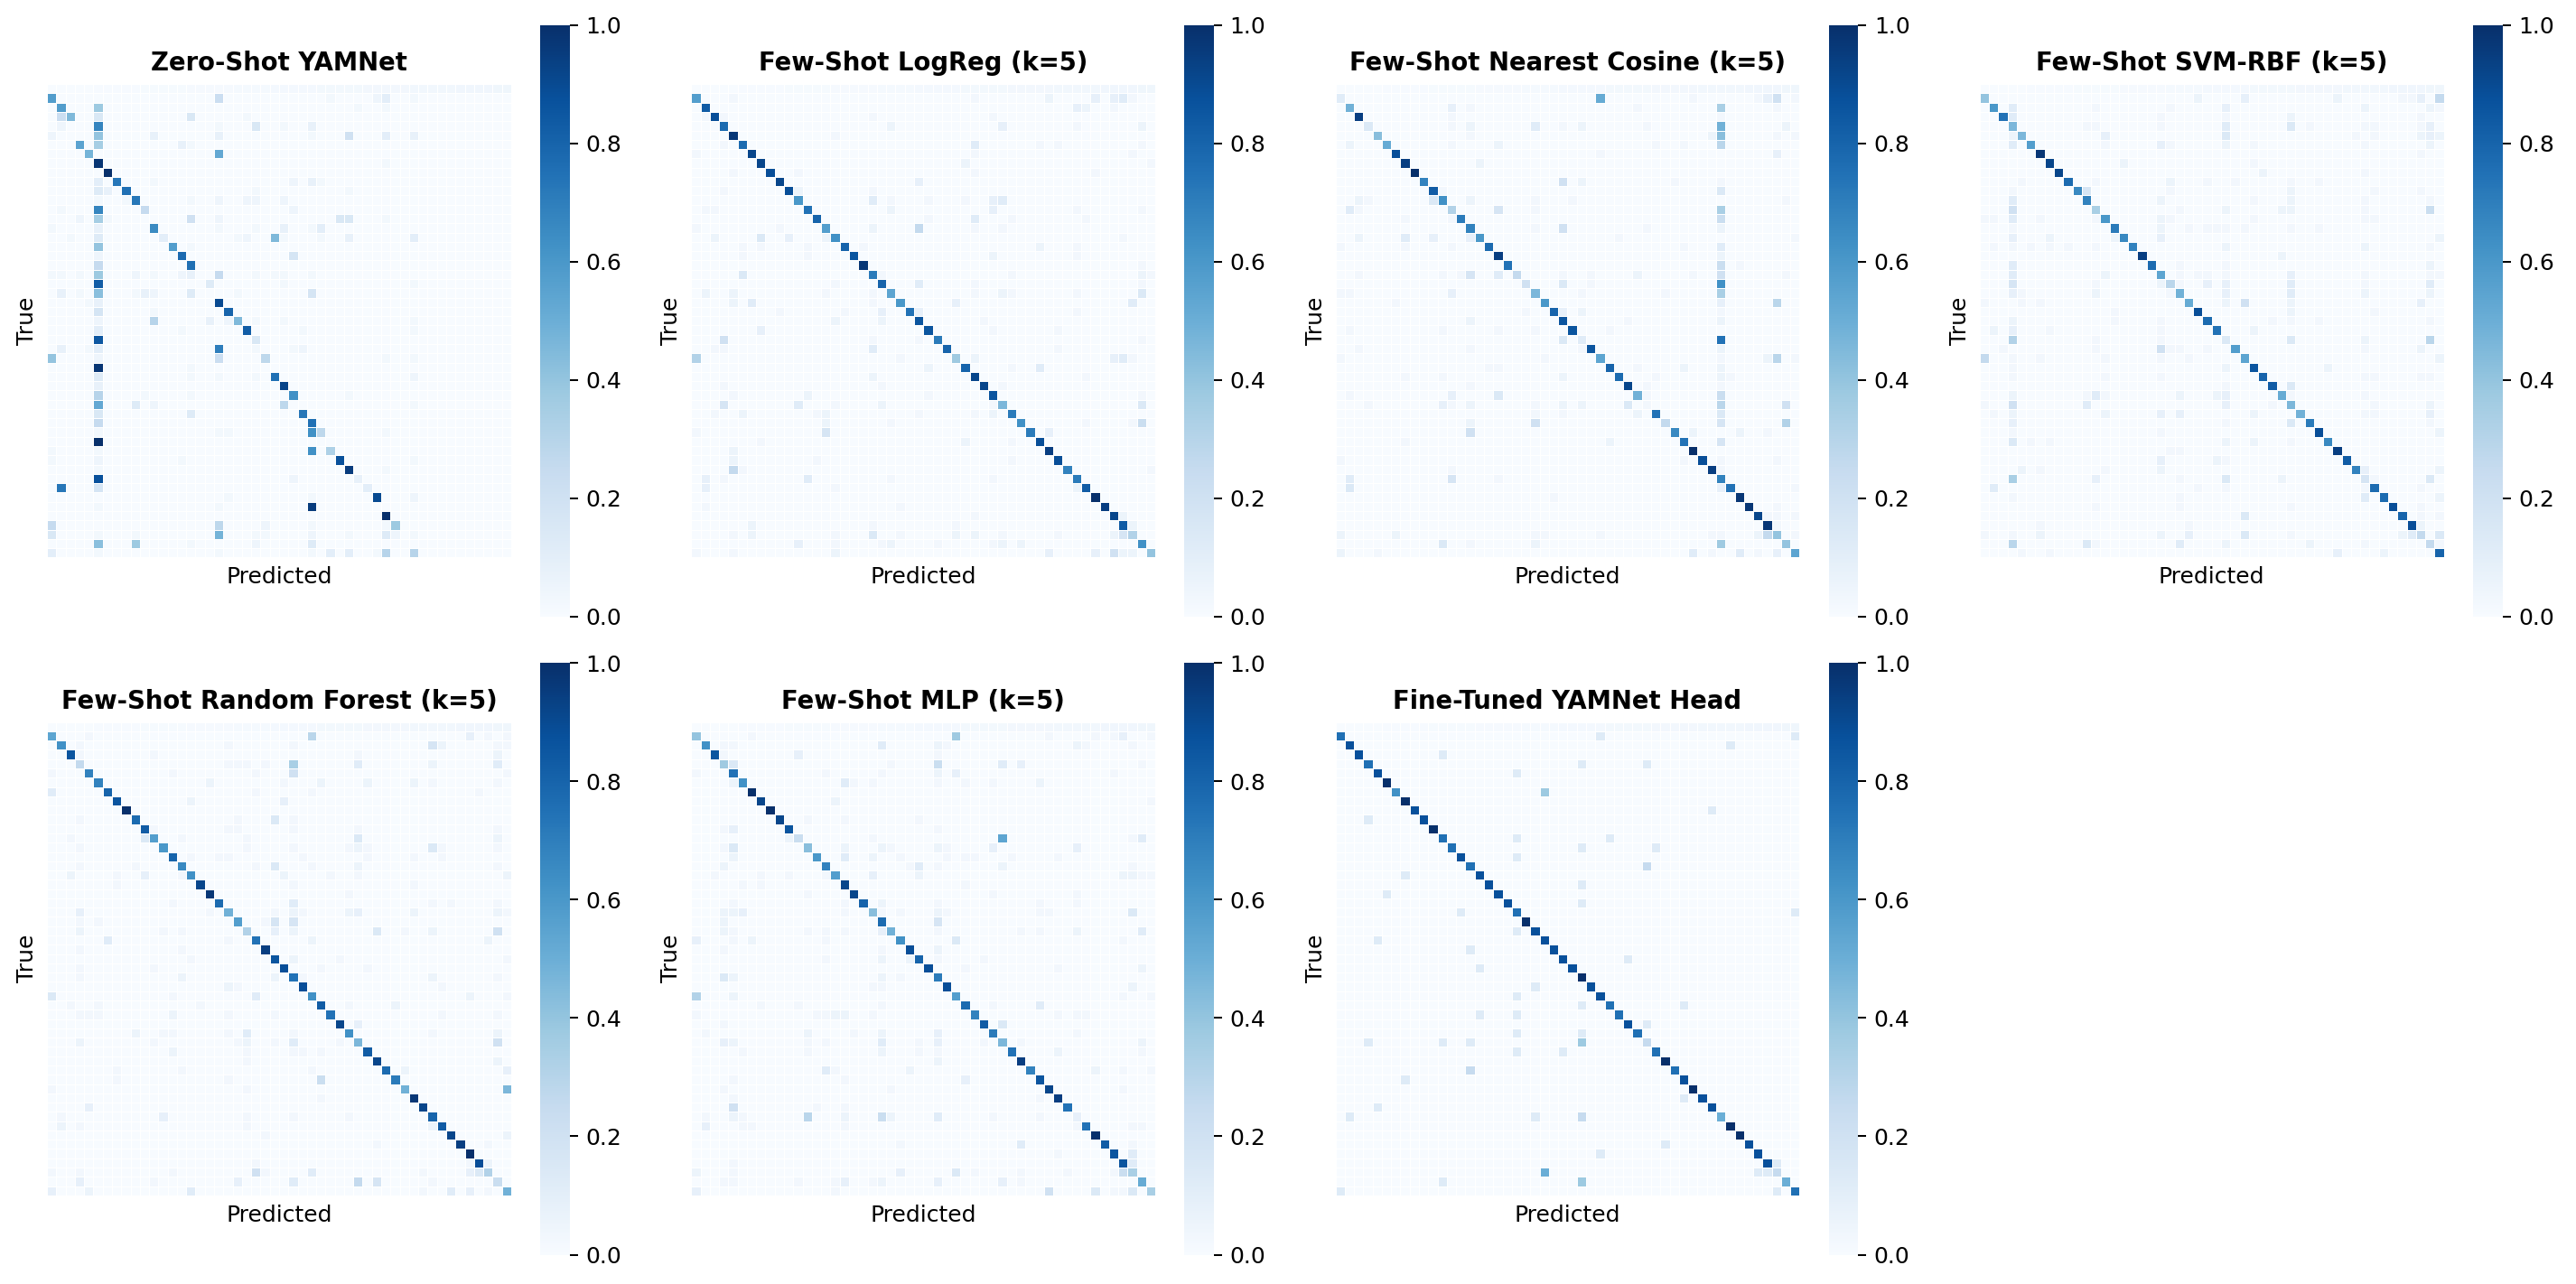


Saved → ESC50_confusions_norm_blue_TWO_ROWS.png


In [33]:

# ------------------------------------------------------------
# 1. Correct ESC-50 confusion matrix filenames (CSV)
# ------------------------------------------------------------
cms_files = [
    ("Zero-Shot YAMNet",               "esc50_zero_shot_confusion_matrix.csv"),
    ("Few-Shot LogReg (k=5)",          "esc50_fewshot_logreg_confusion_matrix.csv"),
    ("Few-Shot Nearest Cosine (k=5)",  "esc50_fewshot_k5_nearestcosine_confmatrix.csv"),
    ("Few-Shot SVM-RBF (k=5)",         "esc50_fewshot_k5_svm_rbf_confmatrix.csv"),
    ("Few-Shot Random Forest (k=5)",   "esc50_fewshot_k5_rf_confmatrix.csv"),
    ("Few-Shot MLP (k=5)",             "esc50_fewshot_k5_mlp_confmatrix.csv"),
    ("Fine-Tuned YAMNet Head",         "esc50_finetune_confmatrix.csv"),
]

# ------------------------------------------------------------
# 2. Load & normalize (row-wise) all confusion matrices
# ------------------------------------------------------------
def row_normalize(cm):
    cm = cm.astype(float)
    row_sums = cm.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1.0   # avoid division by zero
    return cm / row_sums            # each row sums to 1

cms_norm = []
titles = []

for title, file in cms_files:
    cm = pd.read_csv(file, header=None).values   # (50, 50) counts
    cm_norm = row_normalize(cm)                 # convert to proportions
    cms_norm.append(cm_norm)
    titles.append(title)

# ------------------------------------------------------------
# 3. Plot in TWO ROWS, soft blue, shared scale [0, 1]
# ------------------------------------------------------------
def plot_confusions_two_rows(cms, titles, cmap="Blues"):
    N = len(cms)
    n_cols = 4
    n_rows = int(np.ceil(N / n_cols))

    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(4*n_cols, 4*n_rows),
        dpi=180
    )

    axes = np.array(axes).reshape(n_rows, n_cols)

    idx = 0
    for r in range(n_rows):
        for c in range(n_cols):
            ax = axes[r, c]
            if idx >= N:
                ax.axis("off")
                continue

            cm = cms[idx]

            sns.heatmap(
                cm,
                ax=ax,
                cmap=cmap,
                vmin=0, vmax=1,      # VERY IMPORTANT: same scale for all
                cbar=True,
                square=True,
                xticklabels=False,
                yticklabels=False,
                linewidths=0.2,
                linecolor="white"
            )

            ax.set_title(titles[idx], fontsize=11, fontweight="bold")
            ax.set_xlabel("Predicted")
            ax.set_ylabel("True")
            idx += 1

    plt.tight_layout()
    plt.savefig("ESC50_confusions_norm_blue_TWO_ROWS.png",
                dpi=200, bbox_inches="tight")
    plt.show()

plot_confusions_two_rows(cms_norm, titles, cmap="Blues")
print("\nSaved → ESC50_confusions_norm_blue_TWO_ROWS.png")
